In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

import re
from scipy import stats
from tqdm.notebook import tqdm
import time 
from scipy.stats import zscore
import matplotlib.patches as mpatches
from scipy.io.wavfile import read
import textgrid
import subprocess
import shutil
import sys


In [2]:
root_directory = "C:/Users/Nabiya/Box/Academic-Duke/CoganLab/test_4/"

all_plots_directory = os.path.join(root_directory, "stats_plots/")
by_label_directory = os.path.join(root_directory, "stats_plots/by_label/")
by_patient_directory = os.path.join(root_directory, "stats_plots/by_patient/")
by_label_allpatients_directory = os.path.join(root_directory, "stats_plots/by_label_allpatients/")
all_labels_all_patients_directory = os.path.join(root_directory, "stats_plots/all_labels_all_patients/")
pattern = re.compile(r'^D\d+$')
dirs = [all_plots_directory, by_label_directory, by_patient_directory, by_label_allpatients_directory, all_labels_all_patients_directory]
for dir in dirs:
    if not os.path.exists(dir):
        os.makedirs(dir)

In [3]:
temporary_dict = {
    'notoriety': 'notoriety is often mistaken for fame',
    'hut': 'hut',
    'heat': 'heat',
    'hoot': 'hoot',
    'hot': 'hot',
    'there': 'there was once a house that was overrun with mice',
    'the': 'the dog was very proud of the bell'
}

### The MFA output is a single TextGrid file, from which we extract two txt files: phonemes and words (extracted already in the pipeline). For this difference-analysis, we will be using words. However, there is a method-discrepancy between response coding (human) and MFA. The response coding cue_start and cue_end times are for a whole sentence, but in the MFA output, they are for a single word. For that, we need to merge the words in the MFA output to a single line/sentence in order to be able to compare the two.

In [4]:
# this function checks whether rows are within the same second
def end_of_sentence(lines, index, tolerance=0.75):
    # let's assume that the base case is that 
    # this row is the final row in the sentence 
    # and that the row following it has its start time after 2 seconds of the previous row's end time
    # what we want to return is the end time of the sentence
    this_line = lines[index].strip().split('\t')
    next_row = index + 1
    prev_row = index - 1
    if index == len(lines)-1:
        return index, float(this_line[1])

    next_line = lines[next_row].strip().split('\t')
    # let's check if this line is the last line in the lines
    # if so, we will return the end time of the current lineq

    # we want to check if third element in line is void
    # if so, we will return the end time of the index before this one.

    # the case below is where the juice is- 
    # when we can compare end time of the current line with start time of the next line
    if (len(this_line) == 3) and (len(next_line) == 3):
        start, end, label = this_line[0], this_line[1], this_line[2]
        next_row_start, next_row_end, next_row_label = next_line[0], next_line[1], next_line[2]
        start, end, next_row_start, next_row_end = float(start), float(end), float(next_row_start), float(next_row_end)
        if np.abs(end - next_row_start) < tolerance:
        #if next_row_label in temporary_dict:
            return end_of_sentence(lines, next_row)
        else:
            return index, float(end)
        #else:
        #    return index, float(end)

In [5]:
# this function will mutate teh mfa_words file.
# it takes in the file as input

def mutate_mfa_words(patient_path):
    '''
    This function takes in a file path and mutates the mfa words file
    '''
    # read file into pd df and check if the third column is void
    # if it is void, delete the row
    file_path = os.path.join(patient_path, 'mfa_words.txt')
    df = pd.read_csv(file_path, sep='\t', header=None, names=['start', 'end', 'label'])
    df = df.dropna(subset=['label'])
    # overwrite the file with the new df
    # now we want to write the new df to a txt file with the same name but with _mutated
    mutate_1_path = file_path.split('.')[0] + '_mutated.txt'
    df.to_csv(mutate_1_path, sep='\t', header=False, index=False)
    
    
    words = open(mutate_1_path, 'r')
    words_lines = words.readlines()
    output_path = file_path.split('.')[0] + '_mutated_2.txt'
    i = 0
    with open(output_path, 'w') as file:
        while i < len(words_lines):
            curr_line = words_lines[i].strip().split('\t')

            # get the lines where end is within the same sentence
            start, end, label = curr_line[0], curr_line[1], curr_line[2]
            start, end = float(start), float(end)
            index, end = end_of_sentence(words_lines, i)
            # now we want to have the full sentence instead of just one word. 
            # we will write the full sentence to the file
            # even though it would have been more appropriate to fetch the words from each line
            # and then join them together
            # but we are not doing that here- ill just use a dict
            i = index
            sentence = temporary_dict[label]
            file.write(f'{start}\t{end}\t{sentence}\n')
            i += 1

### Running this function, we will have a new txt file named mfa_words_mutated.txt that we can compare to the response coding file. 

In [6]:
reverse_dict = {
    'notoriety is often mistaken for fame': 'notoriety',
    'hut': 'hut',
    'heat': 'heat',
    'hoot': 'hoot',
    'hot': 'hot',
    'there was once a house that was overrun with mice': 'mice',
    'the dog was very proud of the bell': 'dog'
}


In [7]:

def diff_check(patient_path):
    '''
    This function the patient path
    It retrieves the mfa_mutated_2 file and the response_coding file and the annoted events file
    It takes the annotated events file and iterates through it
    for every line, it takes the start and end of the annotated event
    And then it checks if there exists a corresponding event in the mfa_mutated_2 file and the response_coding file
    If there is a corresponding event in both mfa and response, it calculates the difference in start and end times and durations
    It then writes the differences to a file

    the output is a dataframe with the differences in start, end, and duration times and the label of the event and the patient ID
    '''

    annotated_events_path = os.path.join(patient_path, 'annotated_events.txt')
    annotated_file = open(annotated_events_path, 'r')
    annotated_lines = annotated_file.readlines()
    annotated_array = np.array([line.strip().split('\t') for line in annotated_lines])


    patient = patient_path.split('/')[-1]

    resp_path = os.path.join(patient_path, 'response_coding.txt')
    resp_file = open(resp_path, 'r')
    resp_lines = resp_file.readlines()
    resp_array = np.array([line.strip().split('\t') for line in resp_lines])

    mfa_path = os.path.join(patient_path, 'mfa_words_mutated_2.txt')    
    mfa_file = open(mfa_path, 'r')
    mfa_lines = mfa_file.readlines()
    mfa_array = np.array([line.strip().split('\t') for line in mfa_lines])


    diff_table_path = os.path.join(patient_path, 'diff_table.txt')

    with open(diff_table_path, 'w') as file:
        for i in range(len(annotated_array)):
            anno_start, anno_end, label = annotated_array[i]
            anno_start, anno_end = float(anno_start), float(anno_end)
            
            # find any corresponding event in the mfa file and the response file 

            mfa_match = np.where((mfa_array[:,0].astype(float) >= anno_start) & (mfa_array[:,1].astype(float) <= anno_end))[0]

            resp_match = np.where((resp_array[:,0].astype(float) >= anno_start) & (resp_array[:,1].astype(float) <= anno_end))[0]

            if len(mfa_match) > 0 and len(resp_match) > 0 and (len(mfa_match) == len(resp_match) == 1):
                
                mfa_start, mfa_end = mfa_array[mfa_match[0], 0], mfa_array[mfa_match[0], 1]
                resp_start, resp_end = resp_array[resp_match[0], 0], resp_array[resp_match[0], 1]

                mfa_start, mfa_end, resp_start, resp_end = float(mfa_start), float(mfa_end), float(resp_start), float(resp_end)

                diff_start, diff_end = resp_start - mfa_start, resp_end - mfa_end
                diff_duration = (resp_end - resp_start) - (mfa_end - mfa_start)
                label = reverse_dict[label]
                file.write(f'{diff_start}\t{diff_end}\t{diff_duration}\t{label}\t{patient}\n')

            elif len(mfa_match) > 1 or len(resp_match) > 1:
                if len(mfa_match) > 1:
                    time_in_mns = mfa_array[mfa_match, 0].astype(float) / 60
                    raise ValueError(f'Found multiple matches in mfa file for {label} in {patient} in trial {i} time in minutes {time_in_mns}')
                if len(resp_match) > 1:
                    time_in_mns = resp_array[resp_match, 0].astype(float) / 60
                    raise ValueError(f'Found multiple matches in response file for {label} in {patient} in trial {i} time in minutes {time_in_mns}')
            else:
                continue
    

    stats_df = pd.read_csv(diff_table_path, sep='\t', header=None, names=['diff_start', 'diff_end', 'diff_duration', 'label', 'ID'])
    return stats_df

In [8]:

# Assuming the diff_check and other necessary functions are defined elsewhere
# Assuming you also have functions for plotting distributions like plot_distribution(label, data)

# List to hold dataframes for each patient
patient_dfs = []
start = time.time()
for item in tqdm(os.listdir(root_directory), desc= 'Processing Stats', ascii=False, ncols=1000, bar_format='{l_bar}{bar}{r_bar}'):
    patient_path = os.path.join(root_directory, item)
    

    if os.path.isdir(patient_path) and pattern.match(item):
        # skip D34
        if item == 'D34' or item == 'D59' or item == 'D73' or item == 'D20':
            continue
        print(f'Processing Patient {item}')
        mutate_mfa_words(patient_path)
        stats_df = diff_check(patient_path)
        patient_dfs.append((item, stats_df))
        print(f'Patient {item} Done')
print(f'Whole Process Took: {time.time() - start}')

Processing Stats:   0%|                                                                                       …

Processing Patient D22


Patient D22 Done
Processing Patient D23
Patient D23 Done
Processing Patient D24
Patient D24 Done
Processing Patient D26
Patient D26 Done
Processing Patient D27
Patient D27 Done
Processing Patient D28
Patient D28 Done
Processing Patient D29
Patient D29 Done
Processing Patient D30
Patient D30 Done
Processing Patient D31
Patient D31 Done
Processing Patient D32
Patient D32 Done
Processing Patient D35
Patient D35 Done
Processing Patient D57
Patient D57 Done
Processing Patient D60
Patient D60 Done
Processing Patient D61
Patient D61 Done
Processing Patient D63
Patient D63 Done
Processing Patient D64
Patient D64 Done
Processing Patient D65
Patient D65 Done
Processing Patient D66
Patient D66 Done
Processing Patient D69
Patient D69 Done
Processing Patient D71
Patient D71 Done
Processing Patient D72
Patient D72 Done
Processing Patient D81
Patient D81 Done
Processing Patient D82


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Nabiya/Box/Academic-Duke/CoganLab/test_4/D82\\mfa_words.txt'

In [9]:
patient_dfs

[('D22',
      diff_start  diff_end  diff_duration      label   ID
  0     0.015060 -1.103940      -1.119000  notoriety  D22
  1     0.079047 -0.050953      -0.130000       heat  D22
  2     0.129736 -0.021400      -0.151136        hot  D22
  3     0.067289 -0.109710      -0.176999        hut  D22
  4     0.022330 -0.127670      -0.150000        dog  D22
  ..         ...       ...            ...        ...  ...
  65    0.023677 -0.070095      -0.093772        hut  D22
  66    0.037333 -0.082667      -0.120000       heat  D22
  67    0.036622 -0.083378      -0.120000       heat  D22
  68    0.054761 -0.115290      -0.170051        hut  D22
  69    0.018089 -0.231911      -0.250000       mice  D22
  
  [70 rows x 5 columns]),
 ('D23',
      diff_start  diff_end  diff_duration      label   ID
  0     0.102796 -0.221803      -0.324599        hut  D23
  1     0.018788 -1.959012      -1.977800  notoriety  D23
  2     0.049203 -0.199294      -0.248497       heat  D23
  3     0.174477 -0.04202

In [10]:
df = pd.concat([df[1] for df in patient_dfs])


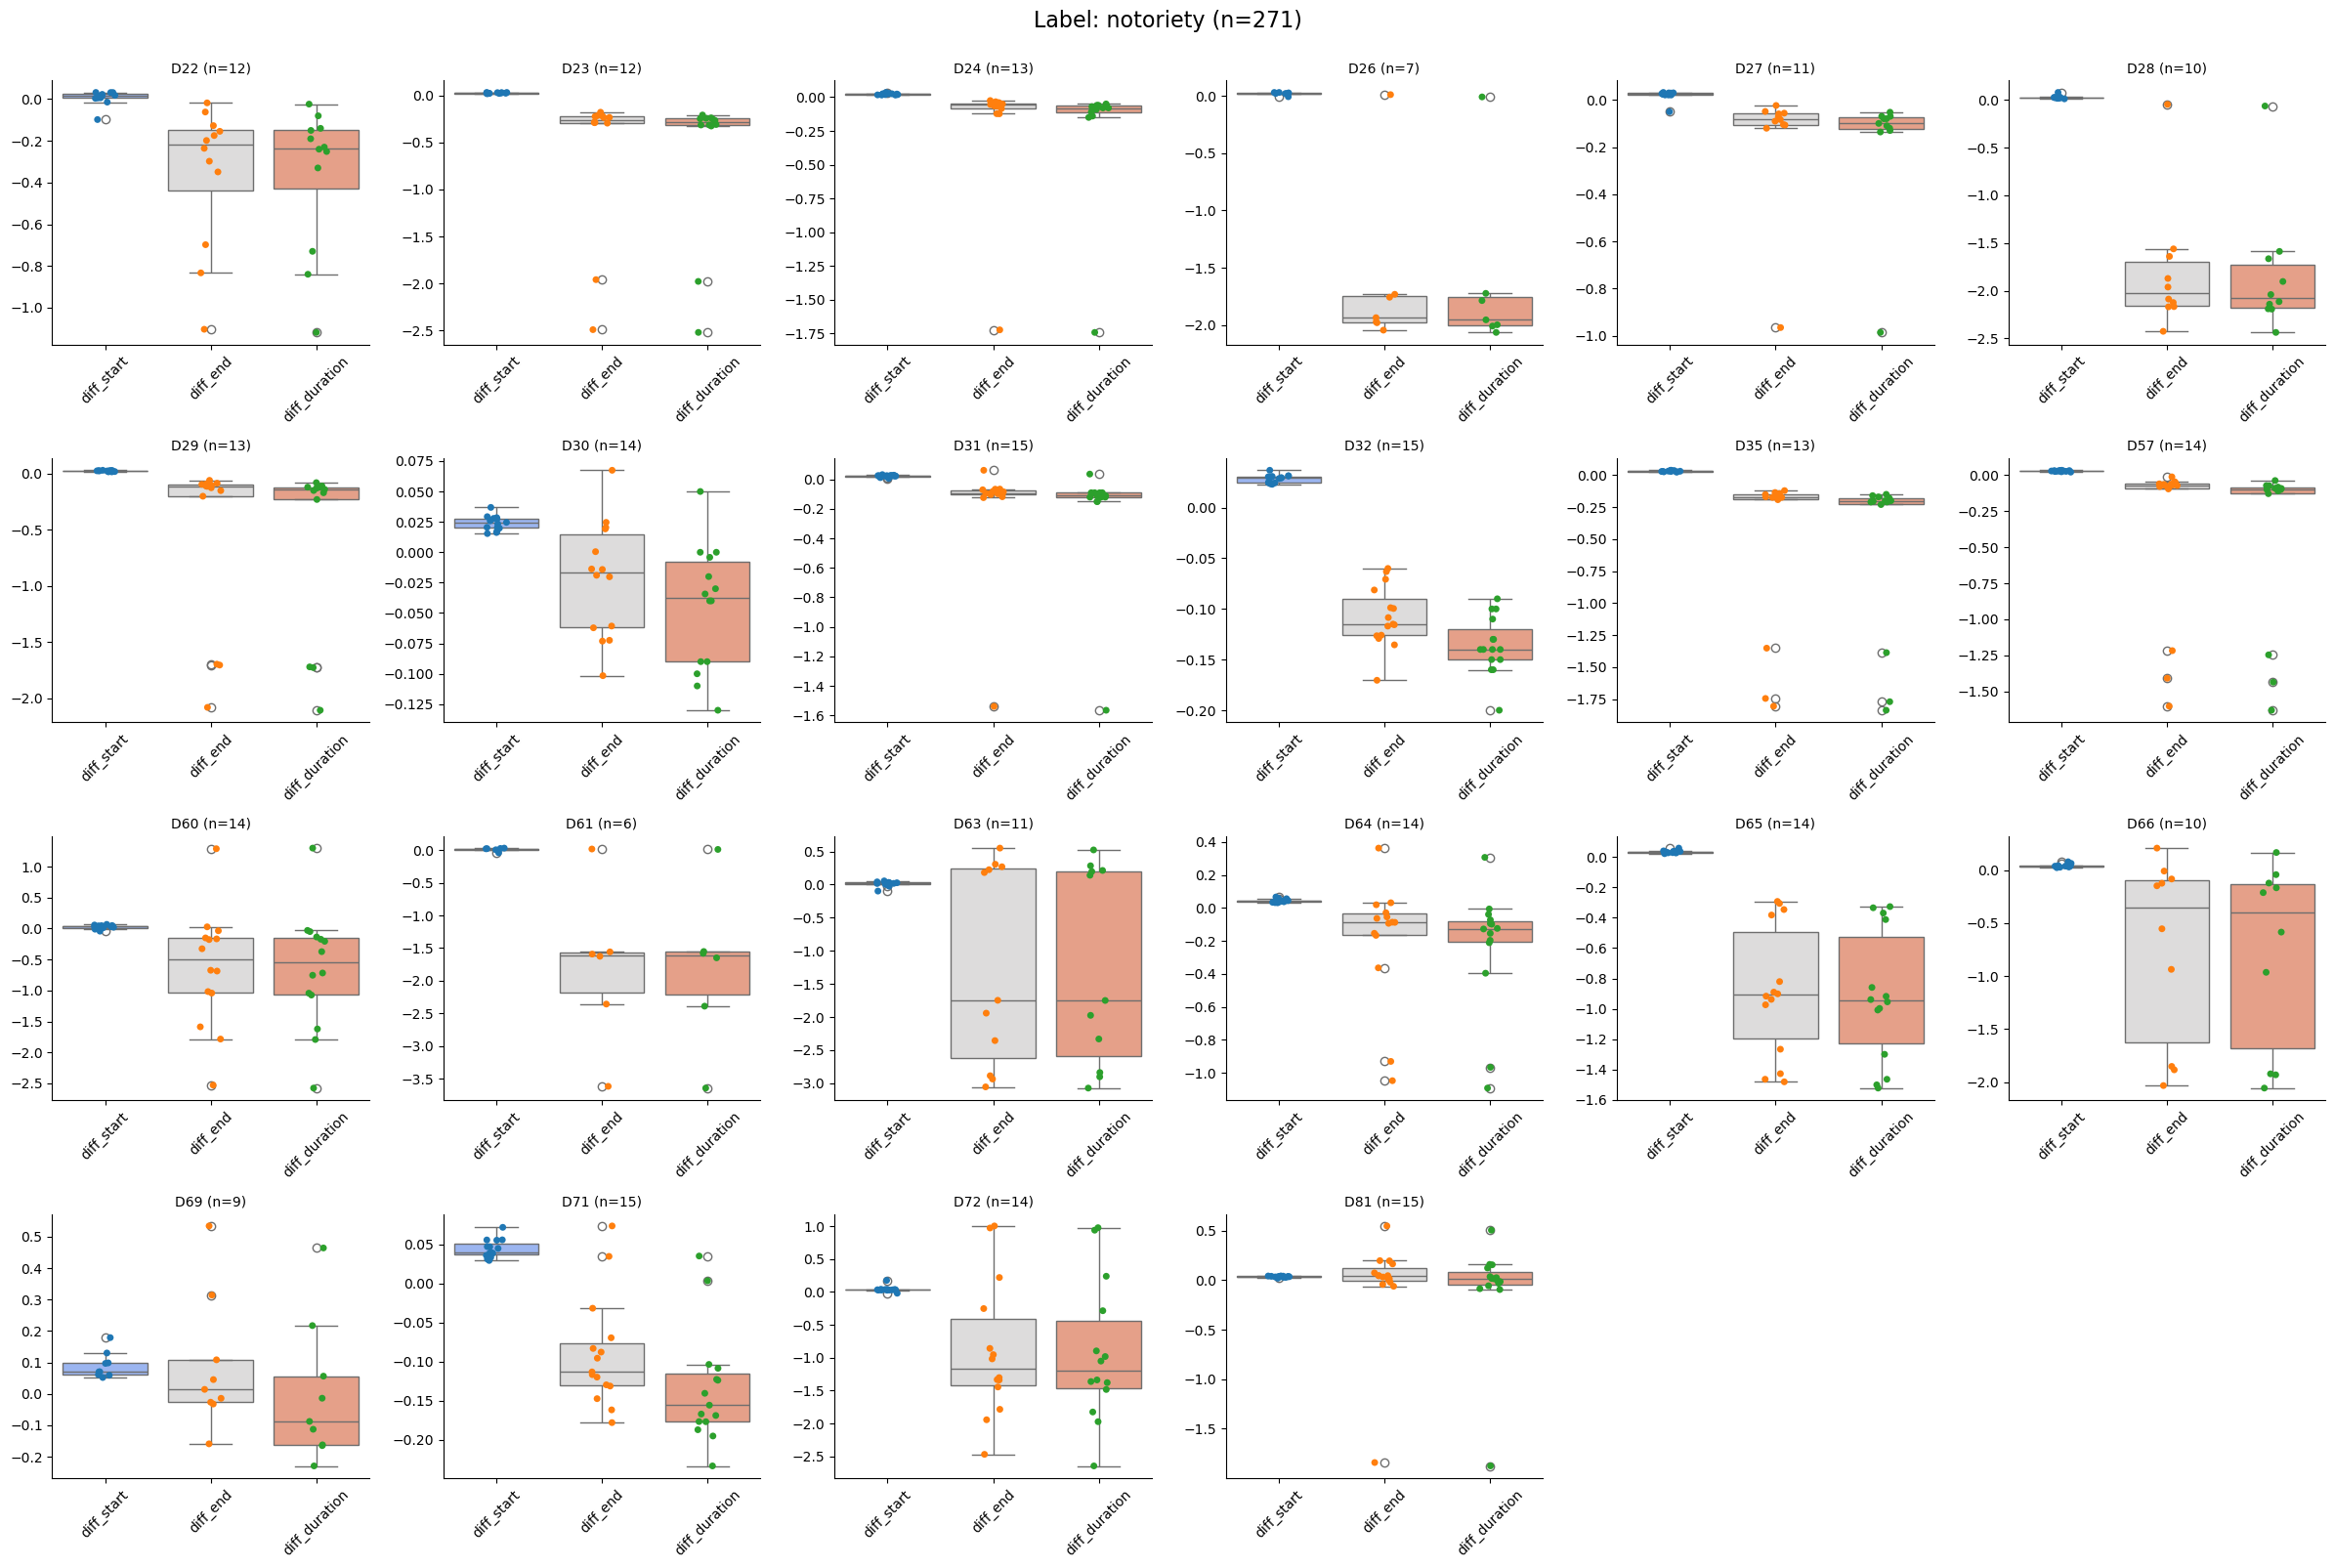

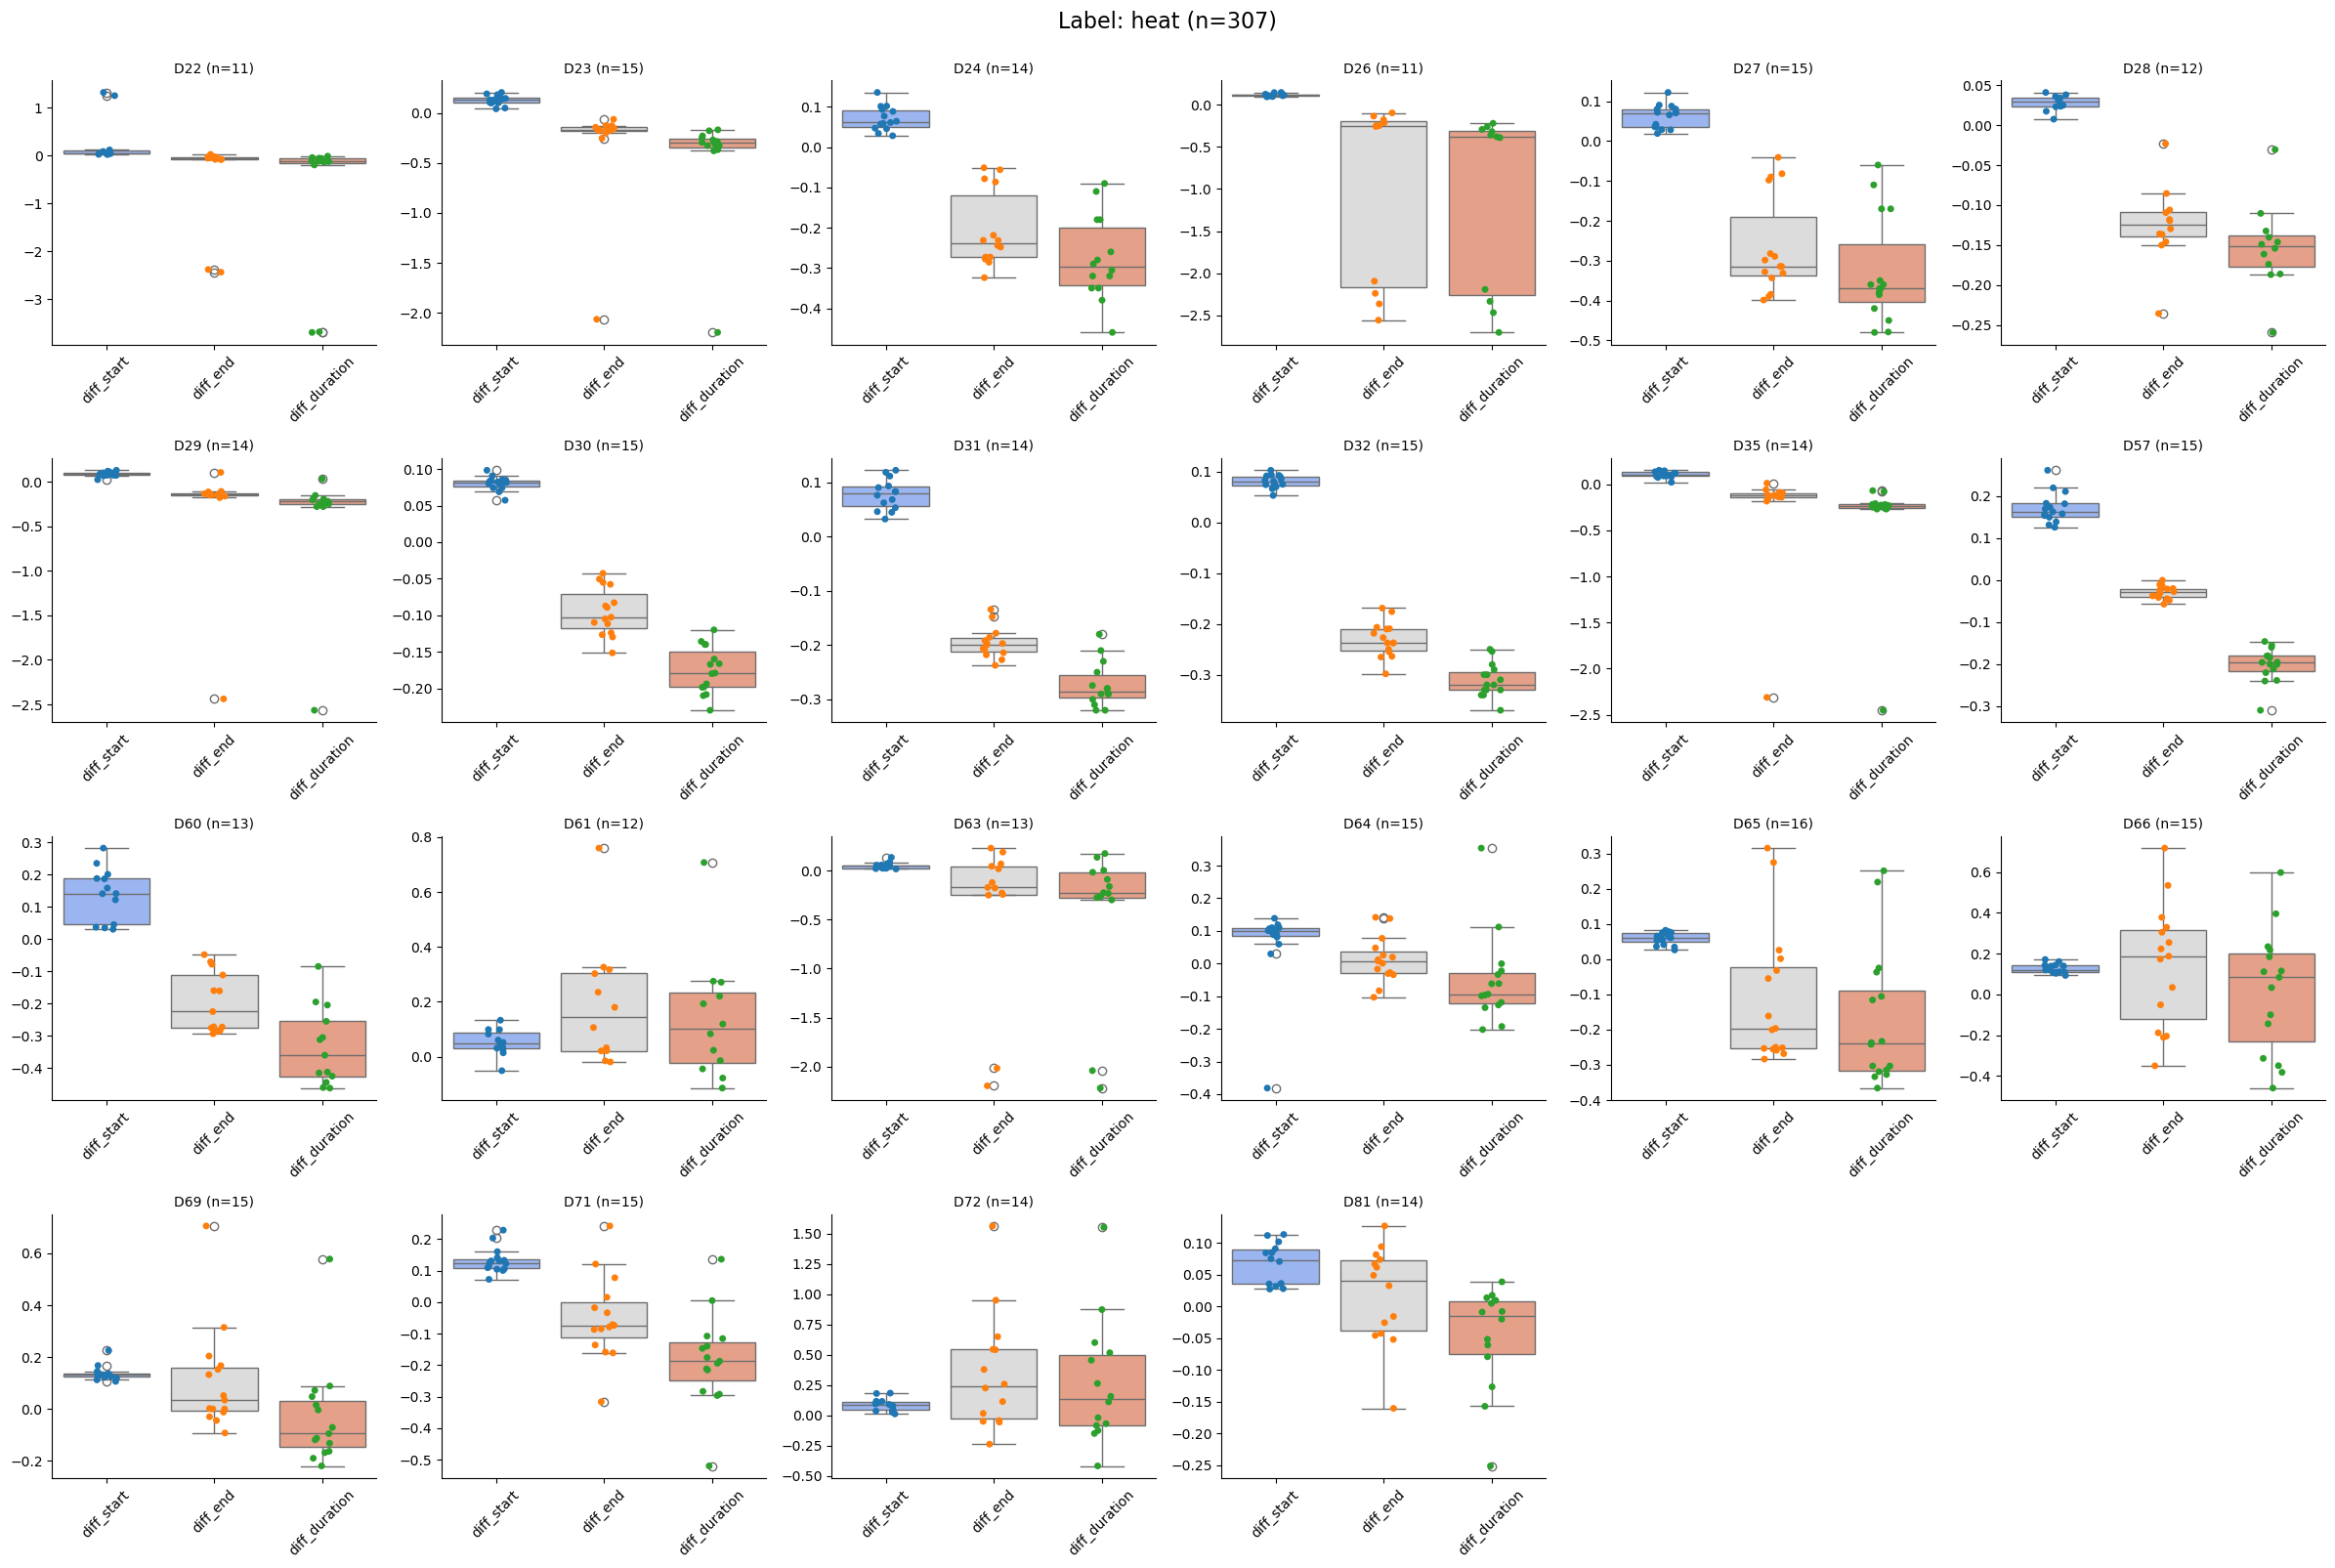

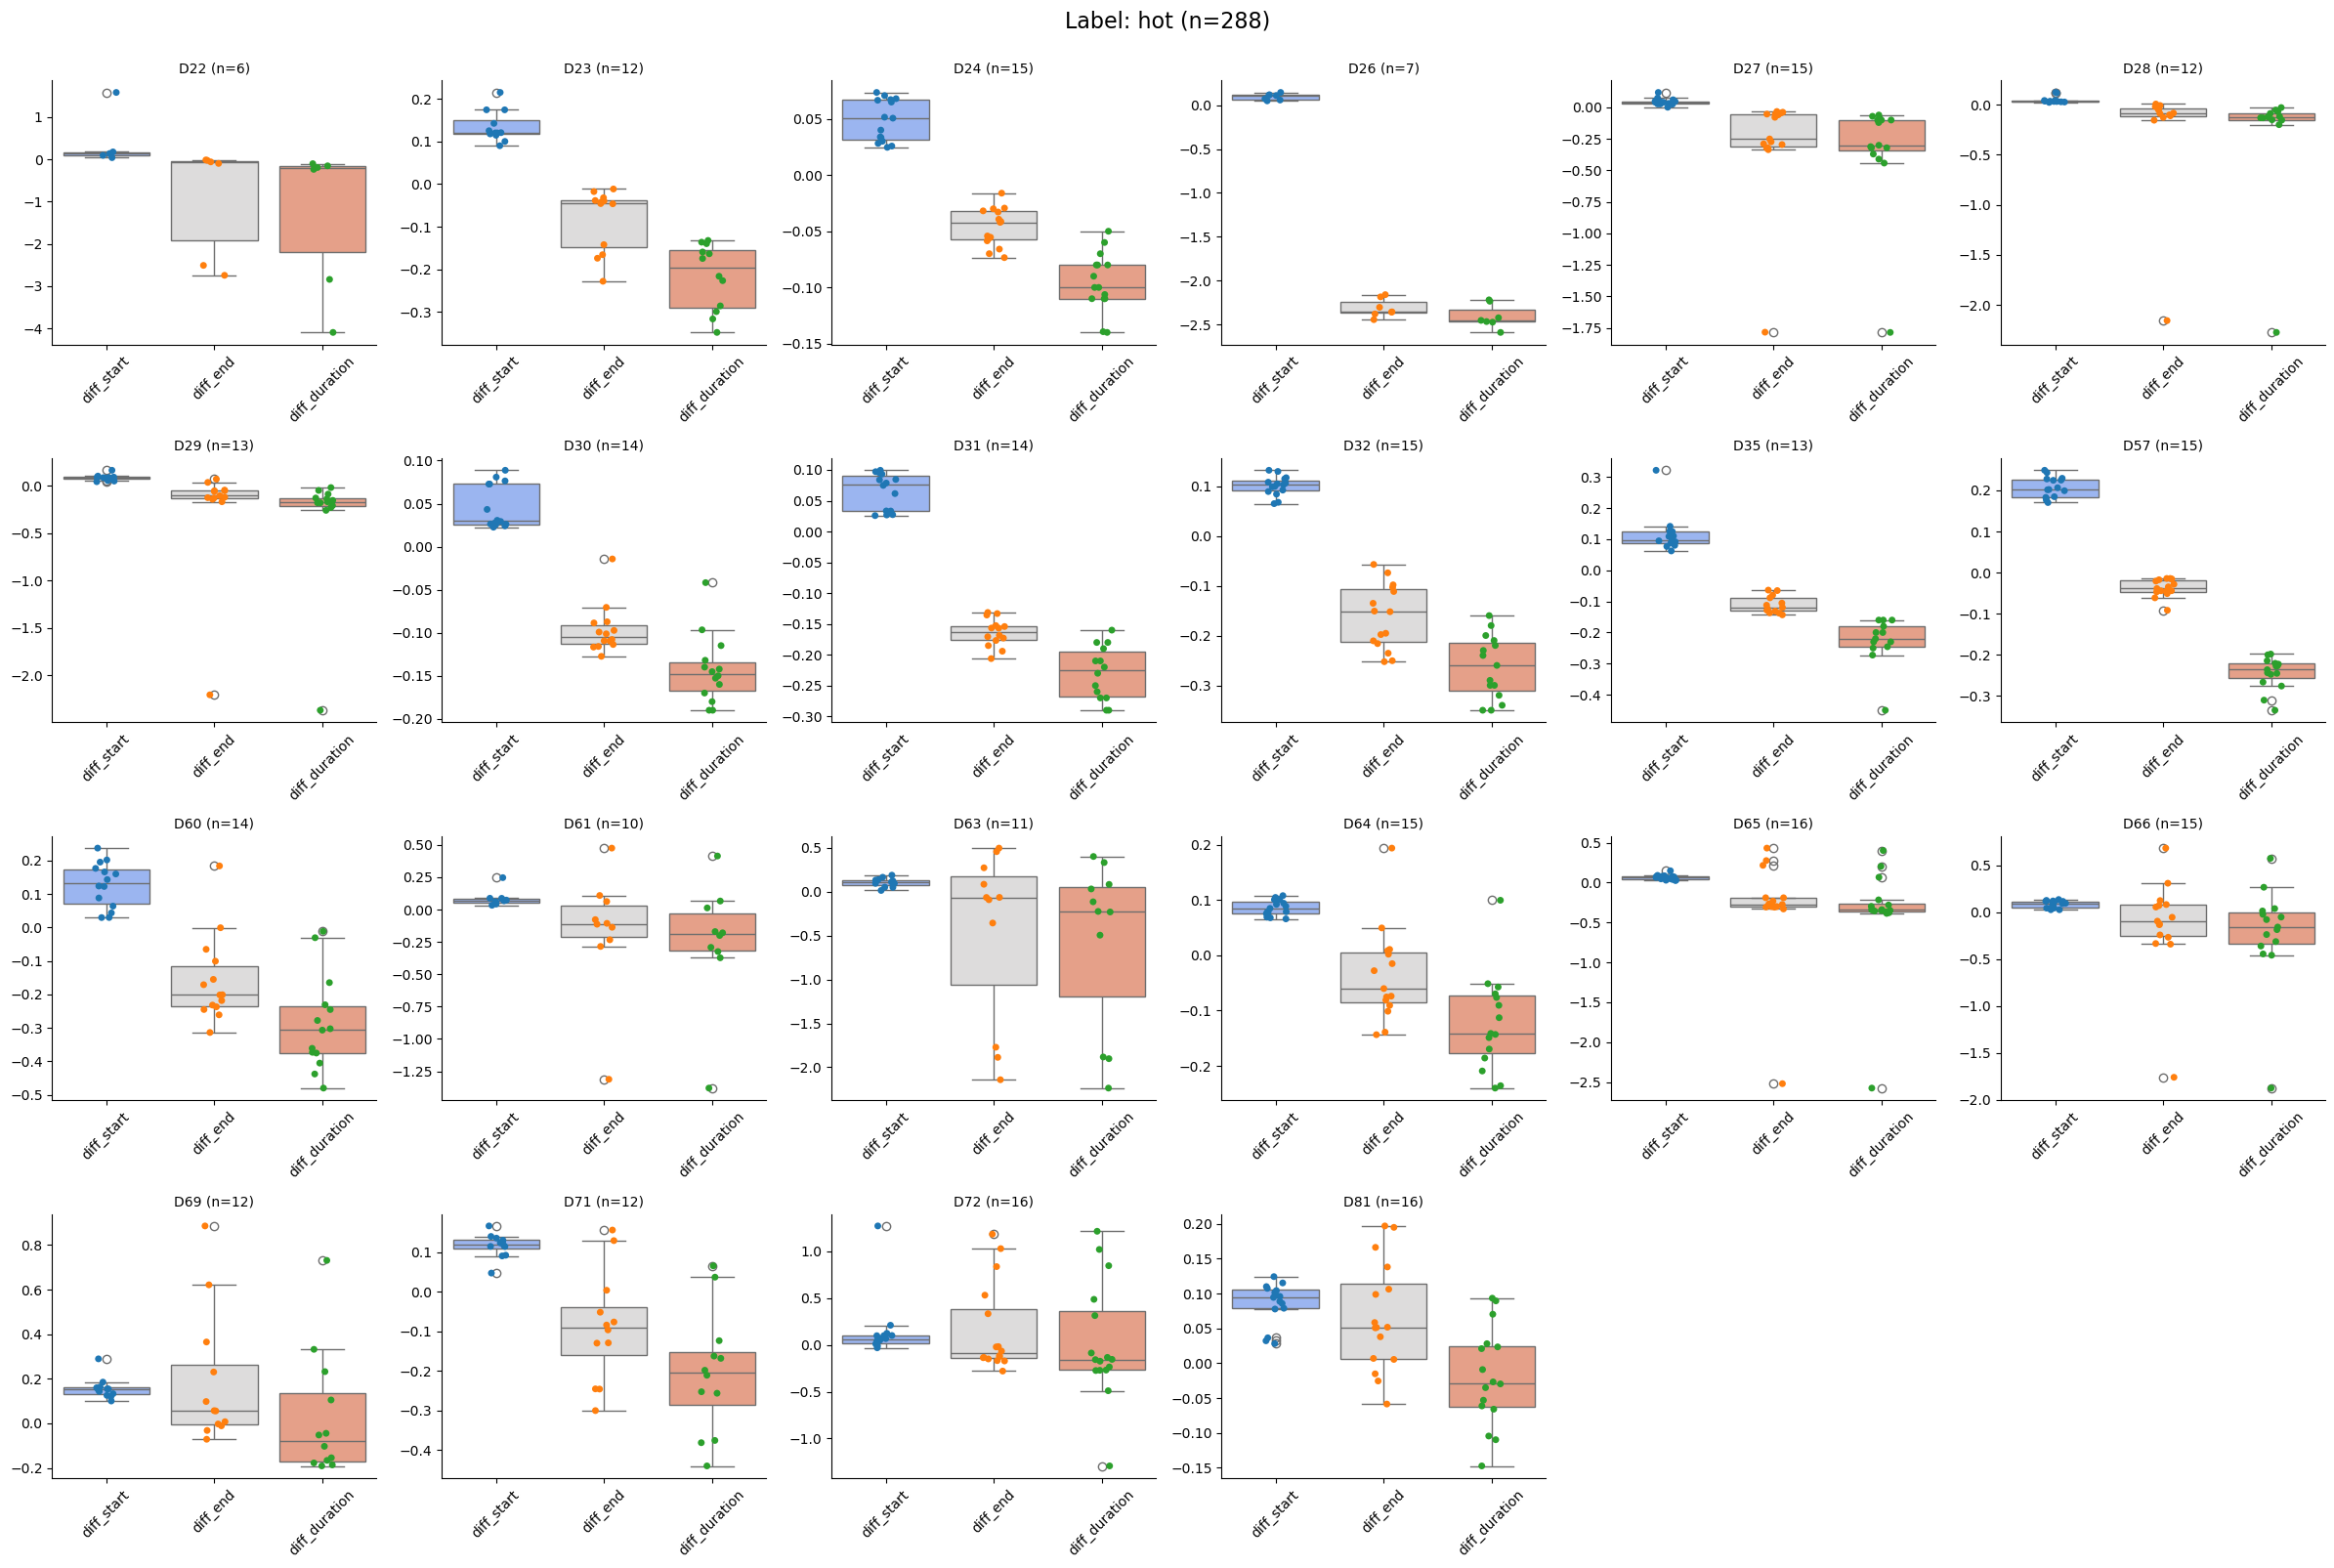

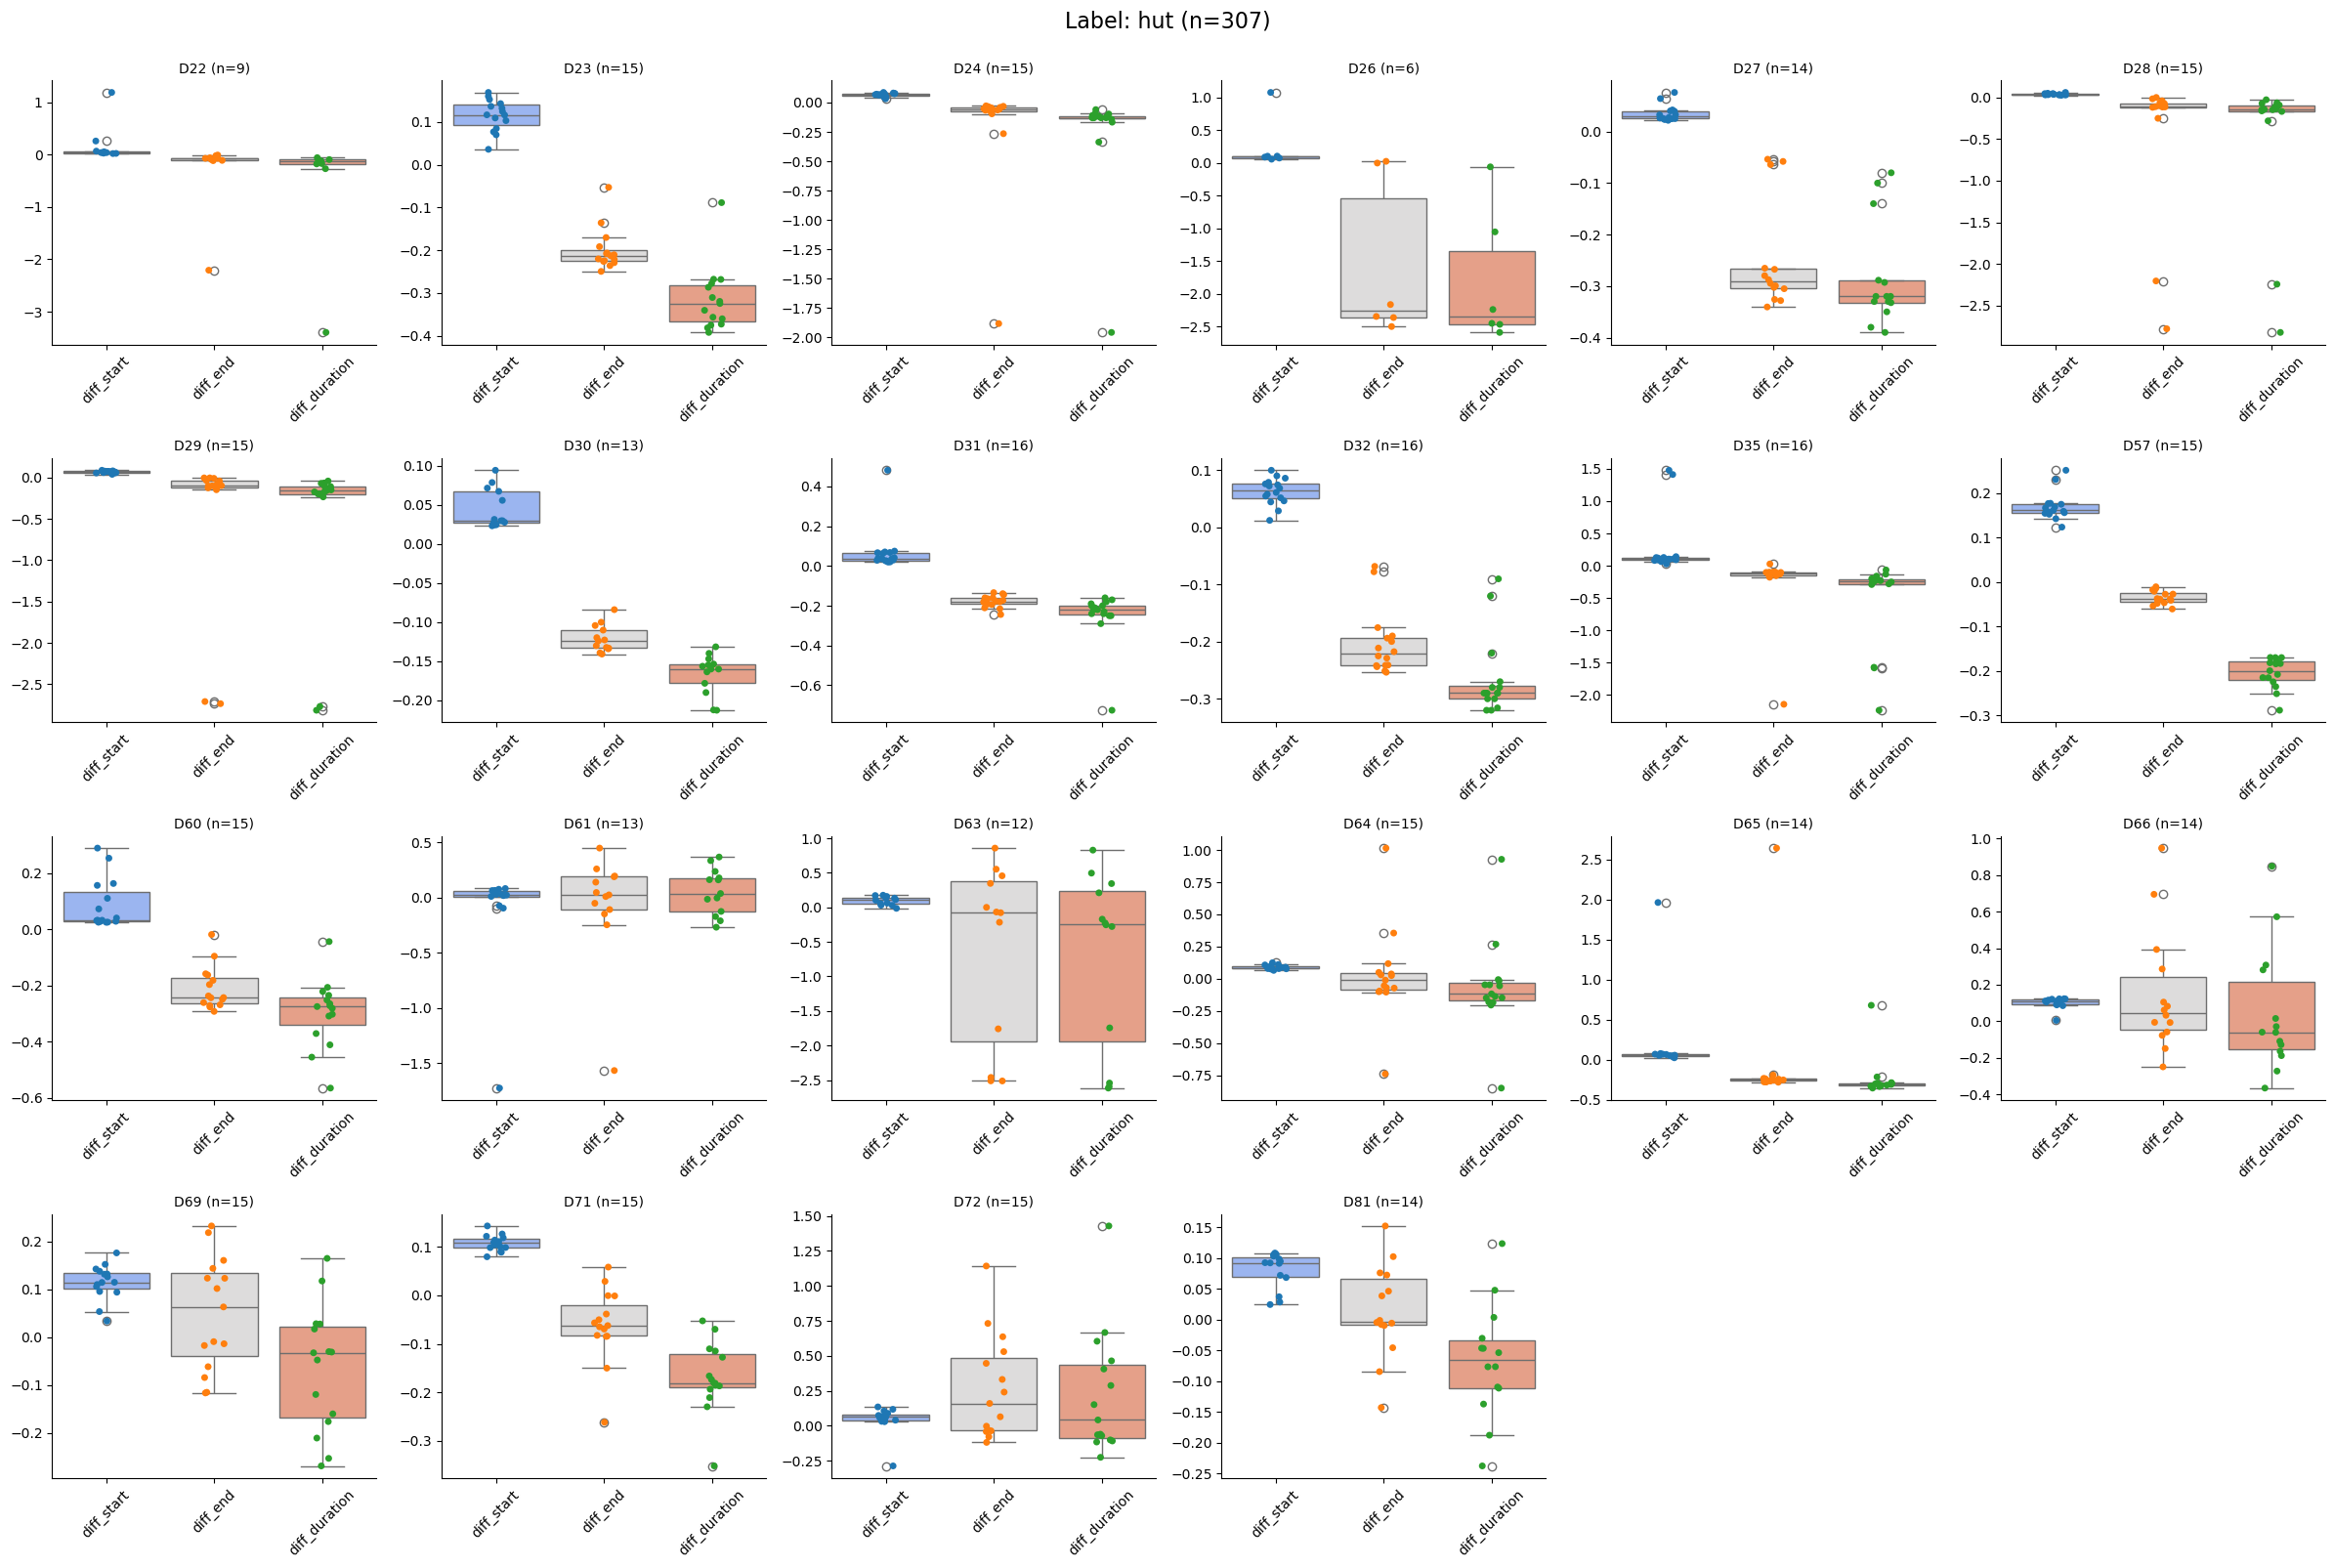

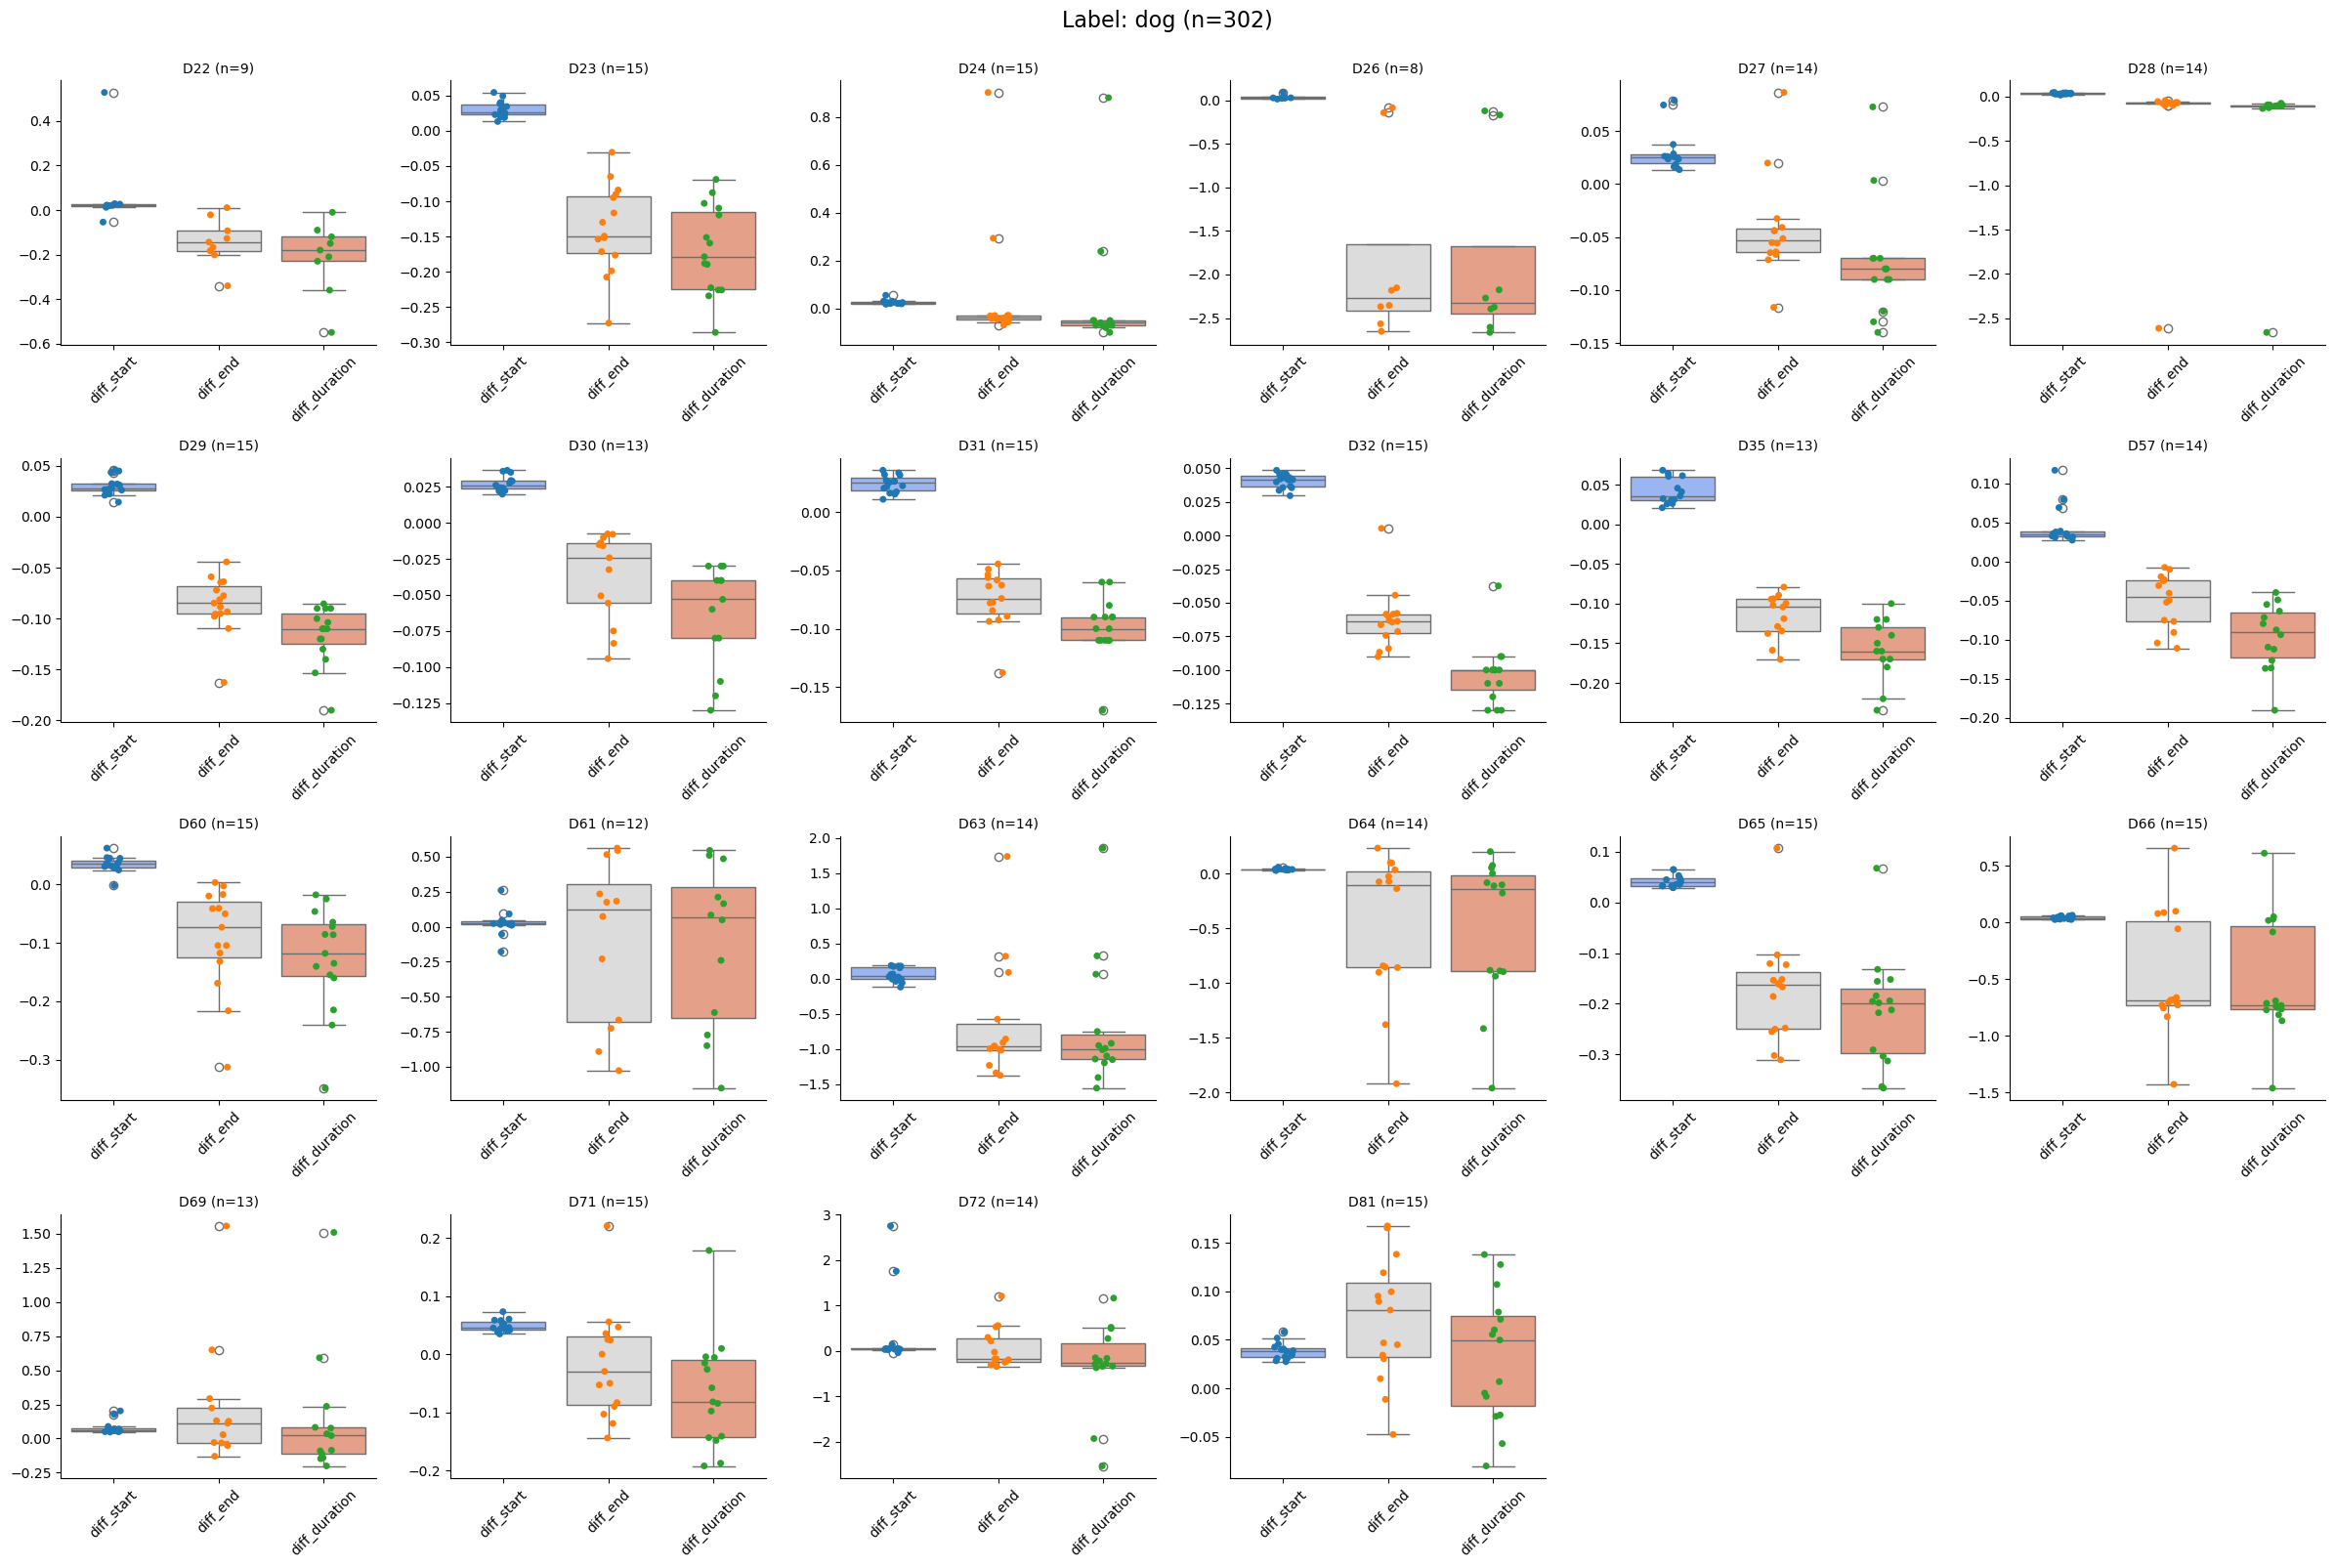

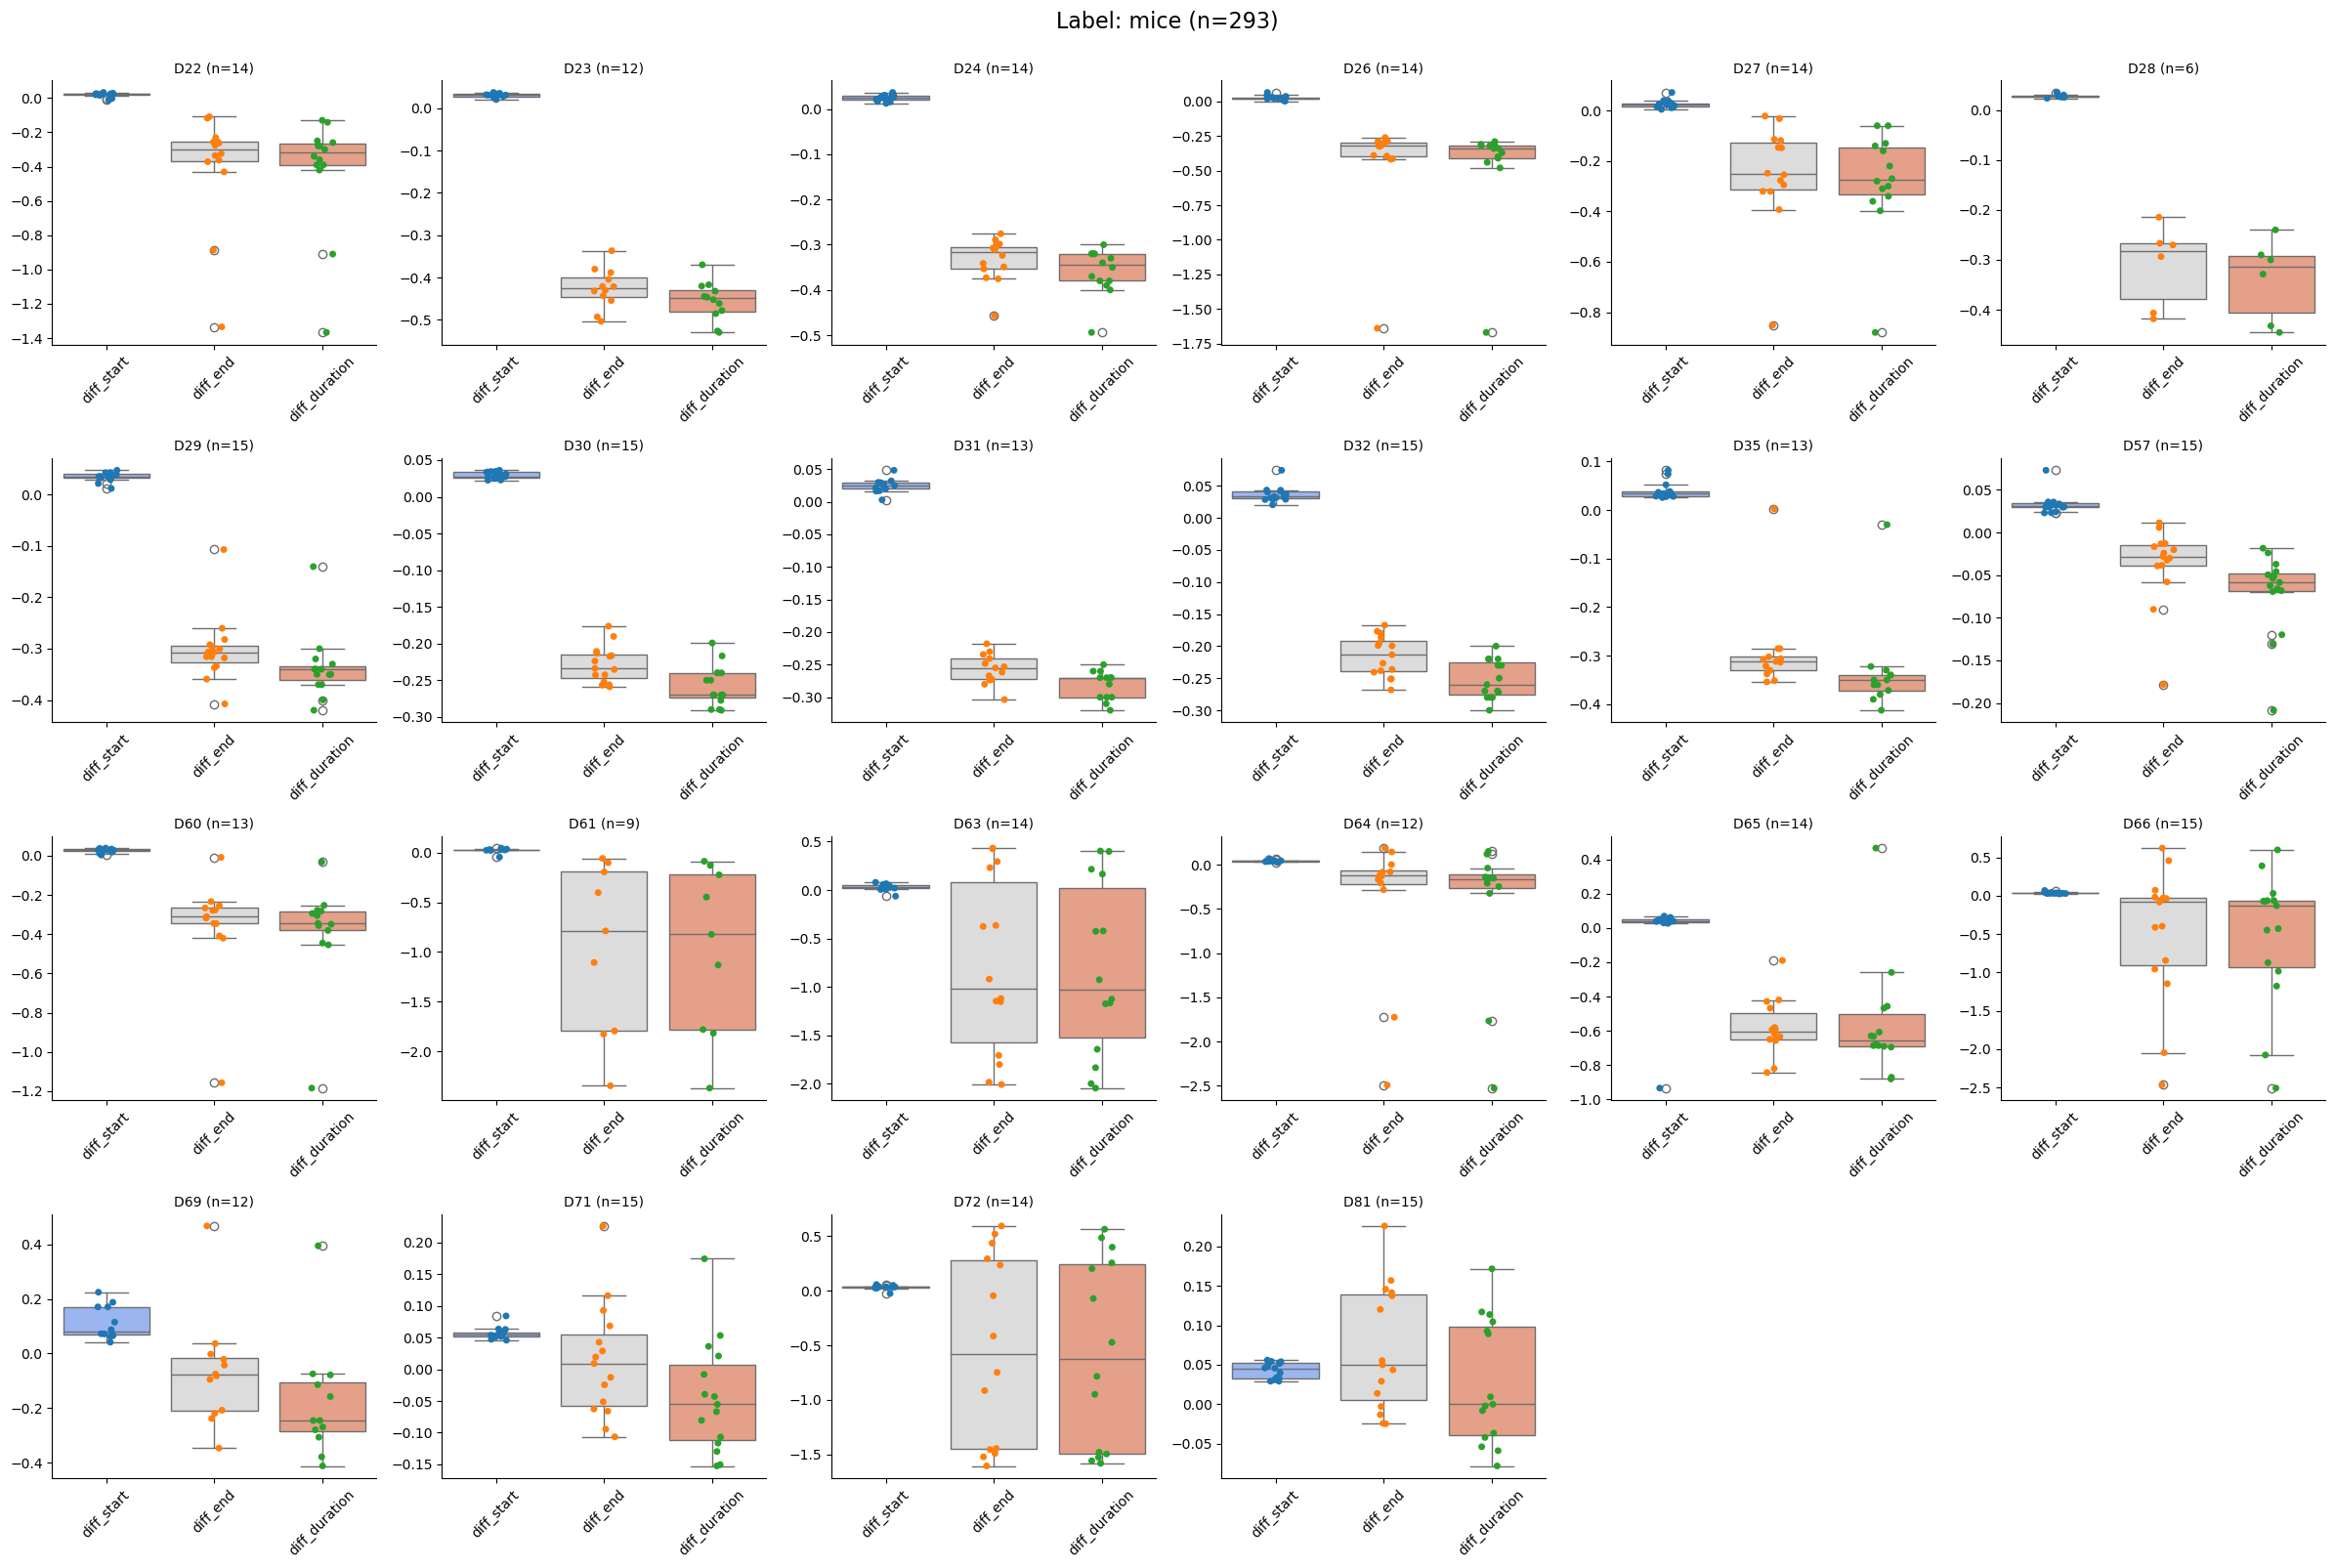

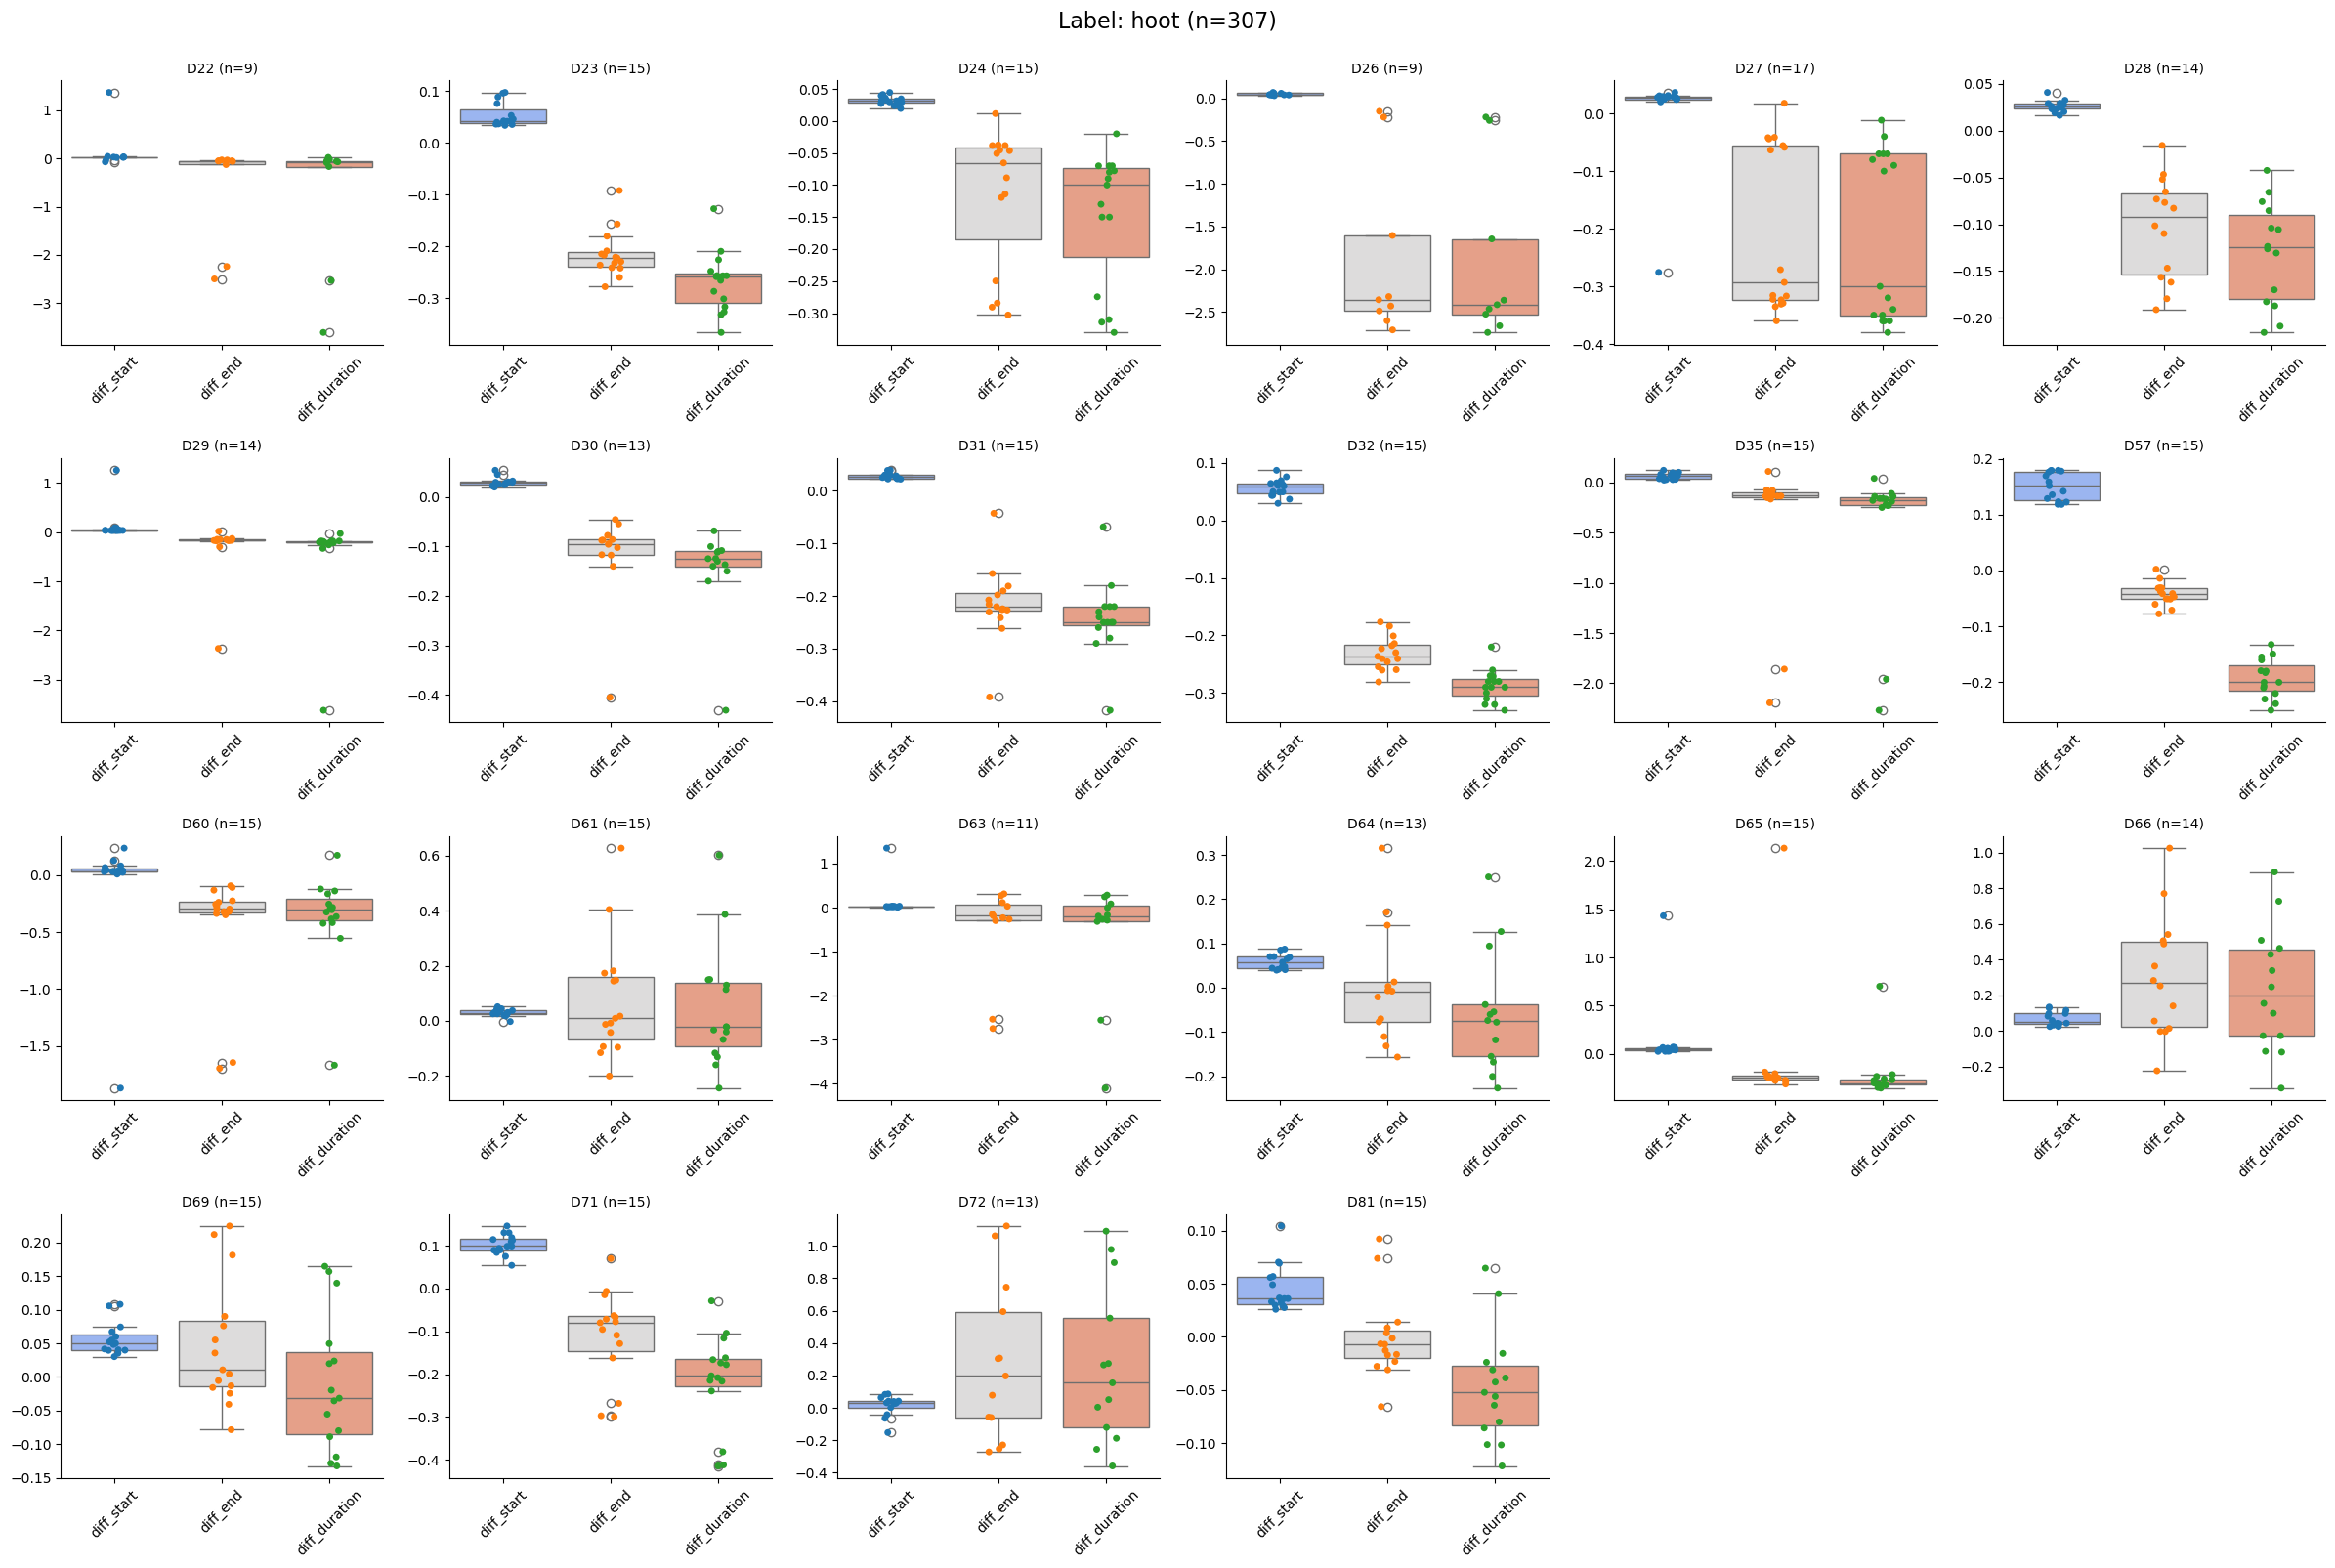

In [11]:
descr_path = os.path.join(by_label_directory, 'stats_bylab.txt')
with open(descr_path, 'w') as f:
    grouped = df.groupby('label')
    
    for label, group in grouped:
        stats = group[['diff_start', 'diff_end', 'diff_duration']].describe()
        
        f.write(f'{label}\n')
        f.write(f'{stats}\n\n\n')  


'''
================================================================================================
================================== PLOTTING BOXPLOTS BY LABEL ==================================
==============================================================================================
'''

for label_value in df['label'].unique():

    df_filtered = df[df['label'] == label_value]
    
    label_count = df_filtered.shape[0]
    
    df_melted = df_filtered.melt(id_vars=['ID', 'label'], value_vars=['diff_start', 'diff_end', 'diff_duration'],
                                 var_name='Measurement', value_name='Value')
    
    measurements_order = ['diff_start', 'diff_end', 'diff_duration']
    
    g = sns.FacetGrid(df_melted, col='ID', margin_titles=True, sharex=False, sharey=False, height=4, col_wrap=6)
    
    g.map(sns.boxplot, 'Measurement', 'Value', 'Measurement',
          order=measurements_order,
          hue_order=measurements_order,
          palette='coolwarm', dodge=False)
    
    g.map(sns.stripplot, 'Measurement', 'Value', 'Measurement',
          order=measurements_order,
          hue_order=measurements_order,
          palette='tab10',  
          jitter=True, dodge=False)
    
  
    g.set_axis_labels('', '')
    
    g.fig.suptitle(f'Label: {label_value} (n={label_count})', size=16, y=1)
    for ax, (id_value, count) in zip(g.axes.flat, df_filtered.groupby('ID').size().reset_index(name='count').values):
        ax.set_title(f'{id_value} (n={count})', fontsize=10)

    

    g.fig.subplots_adjust(wspace=0.4, hspace=0.4)
    for ax in g.axes.flat:
        plt.setp(ax.get_xticklabels(), rotation=45)
    g.tight_layout()
    plt.savefig(f'{by_label_directory}{label_value}_boxplot.png')
    plt.show()
    plt.close()


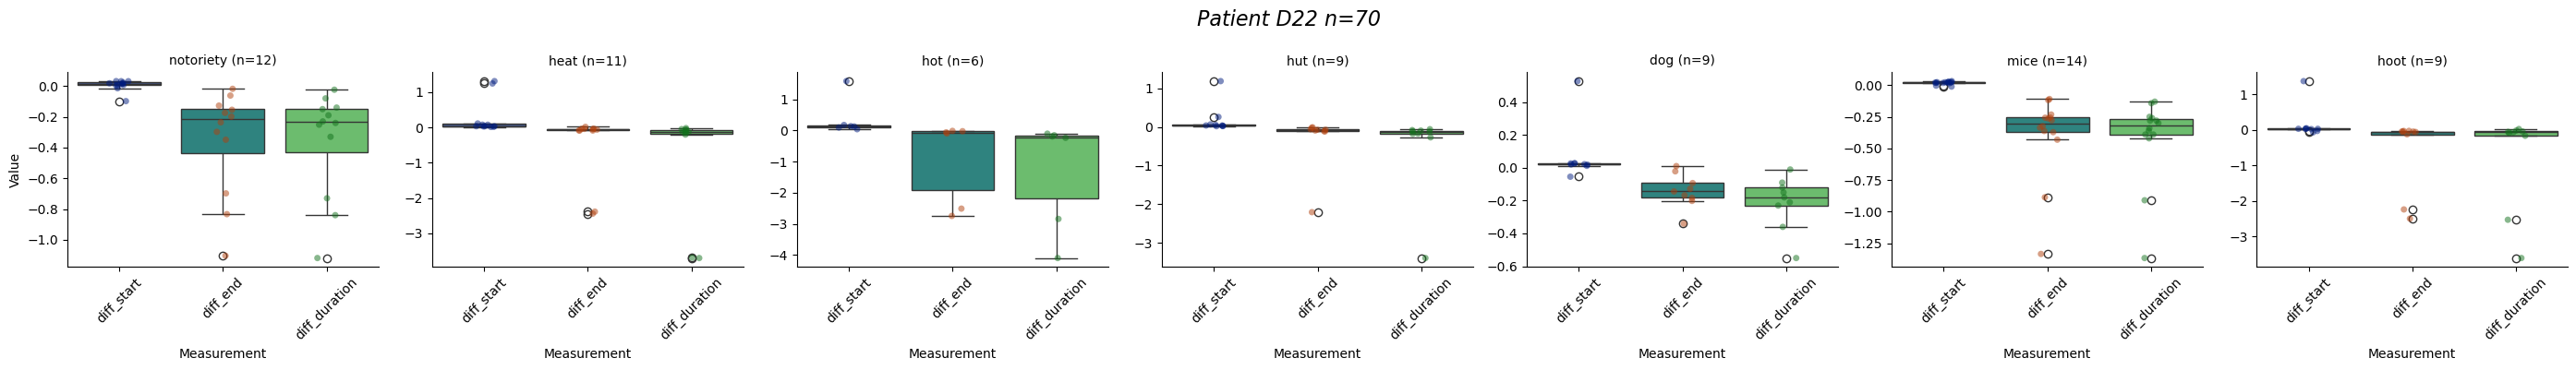

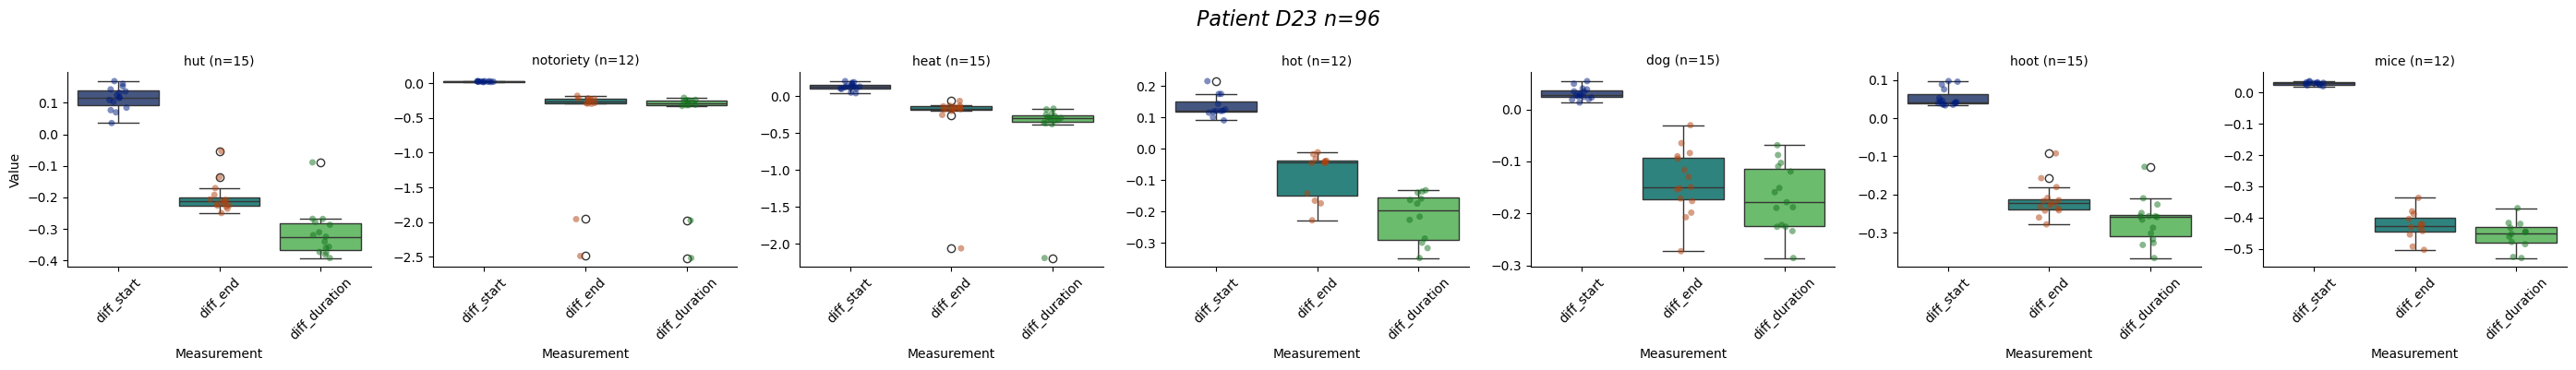

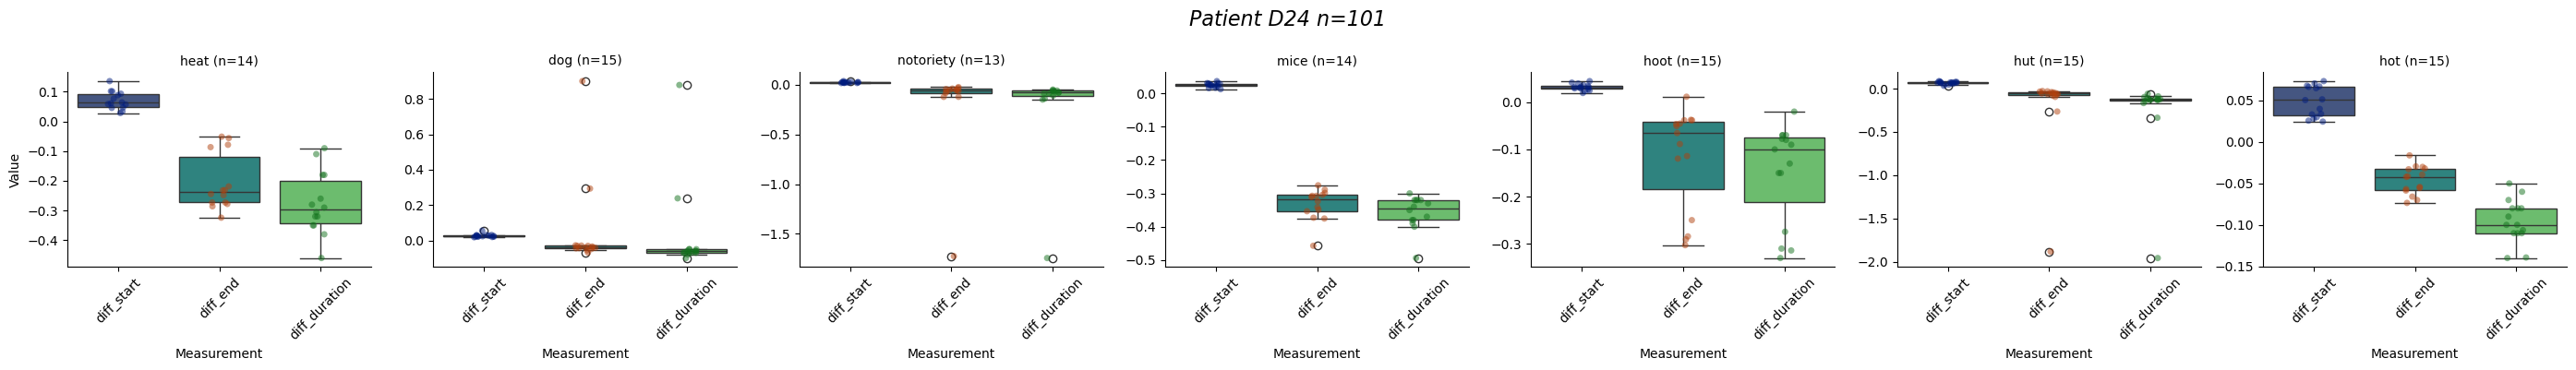

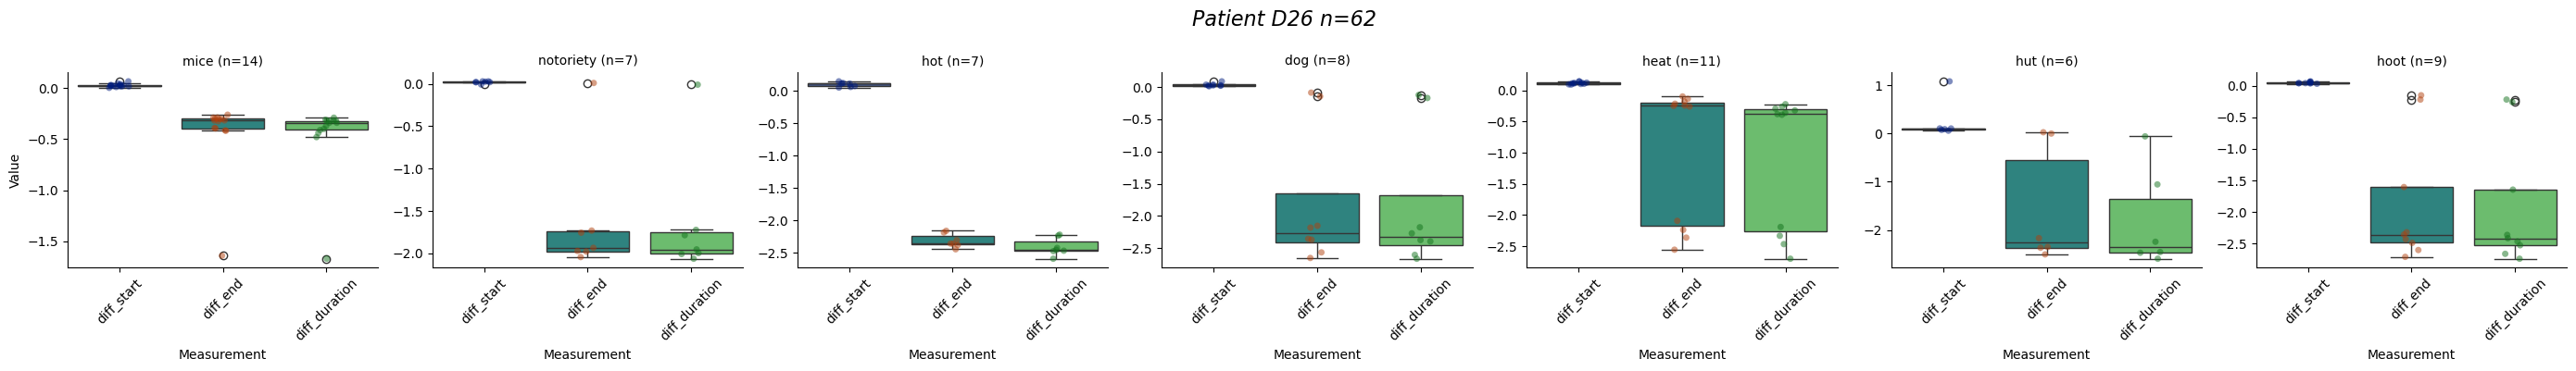

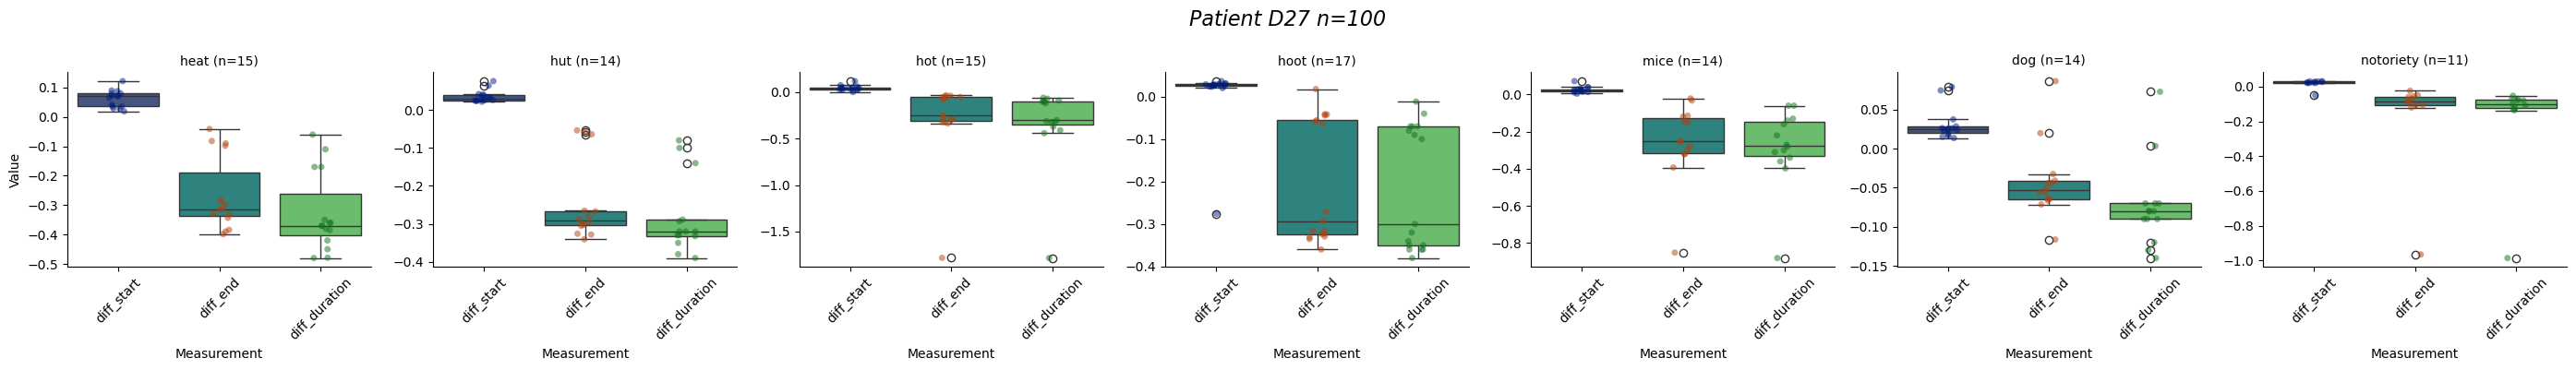

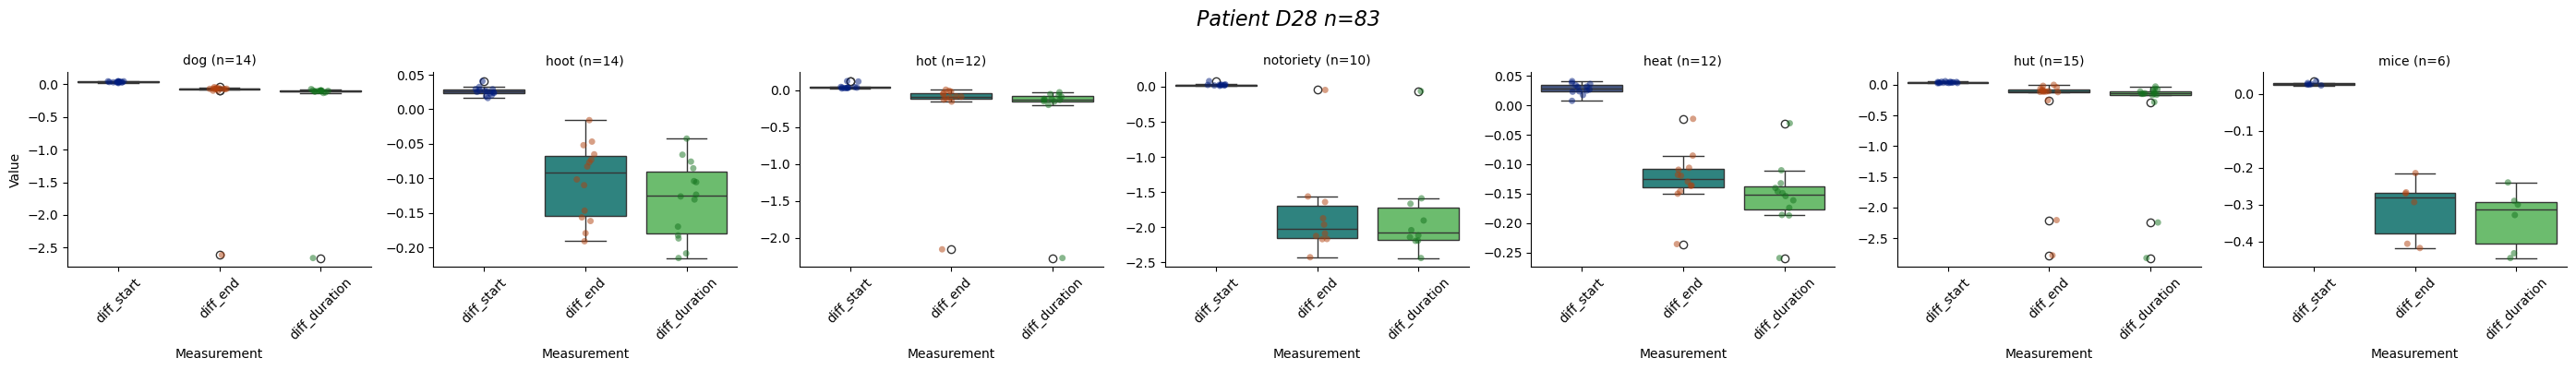

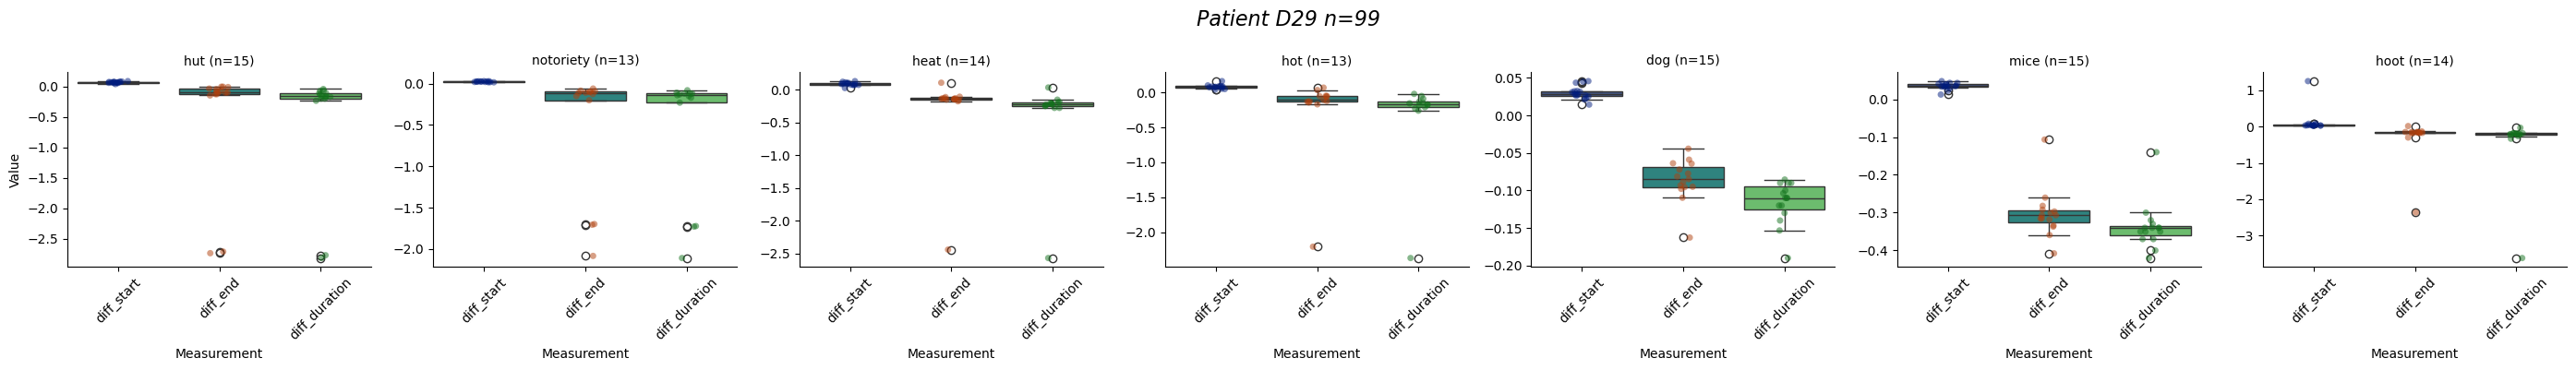

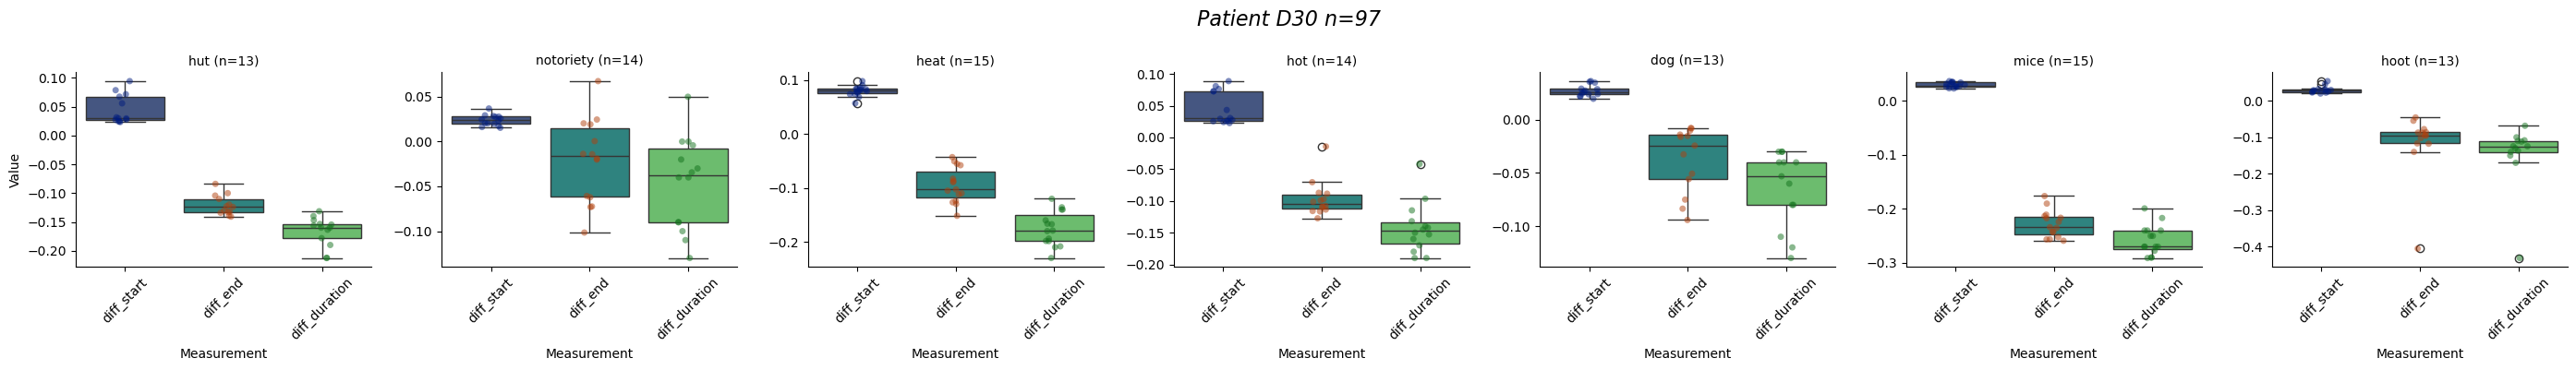

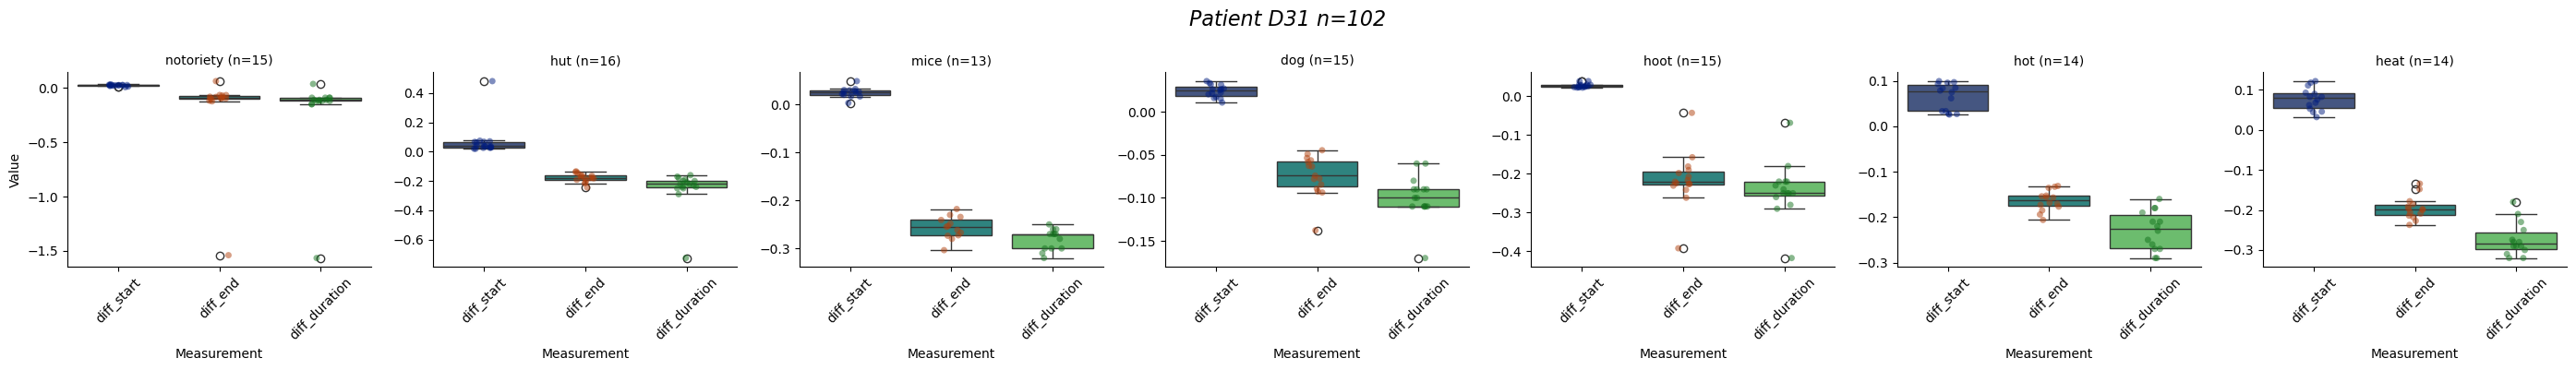

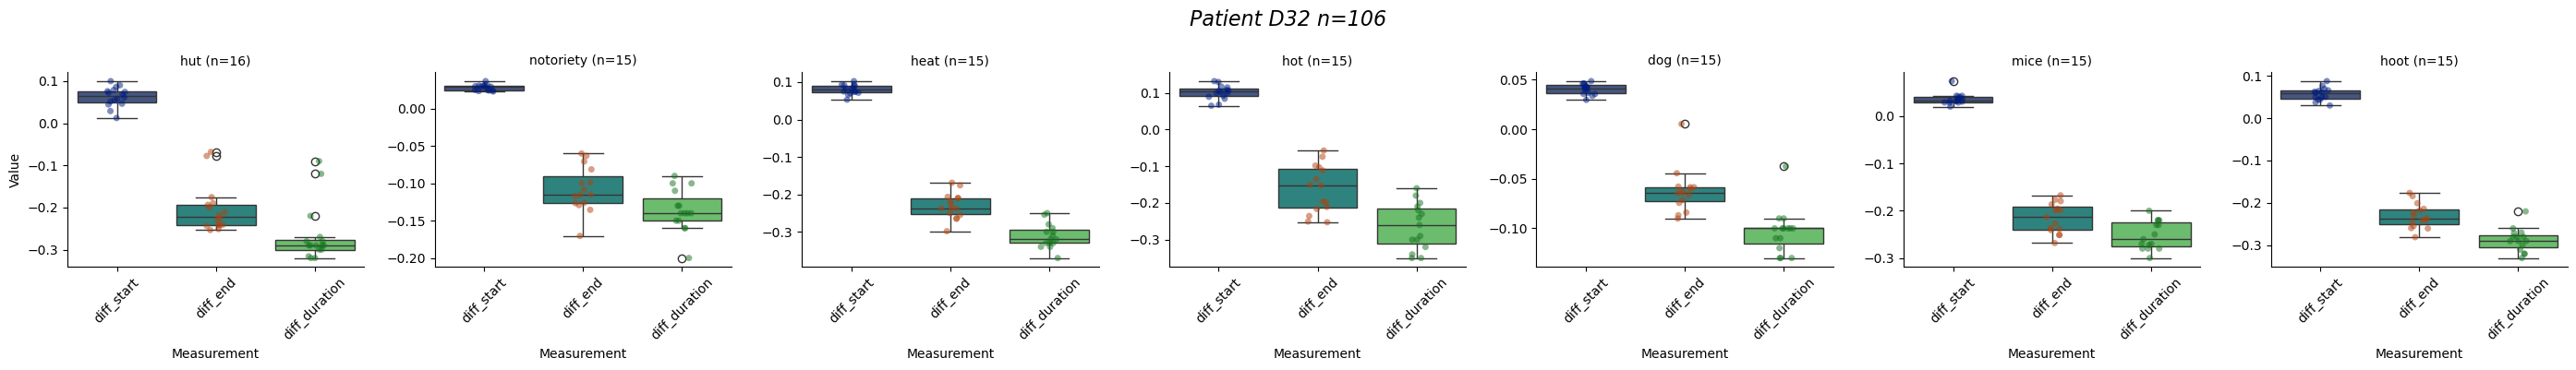

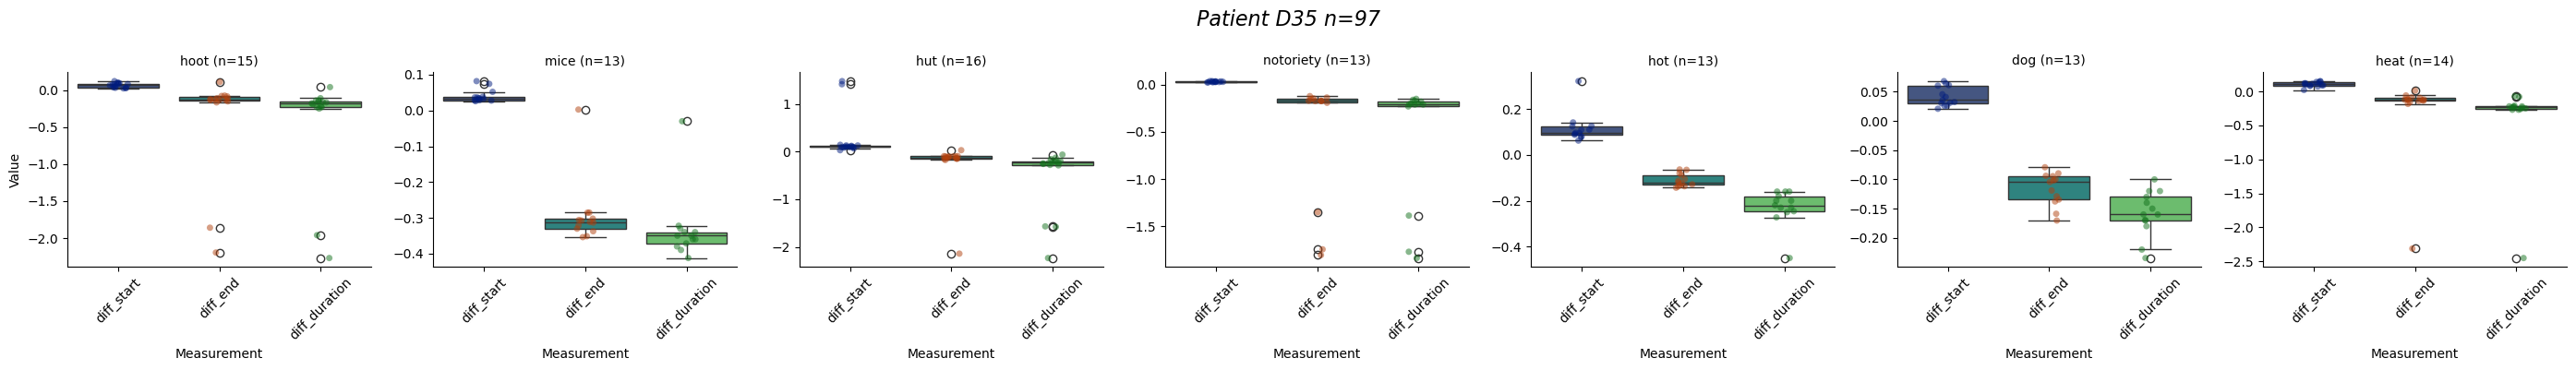

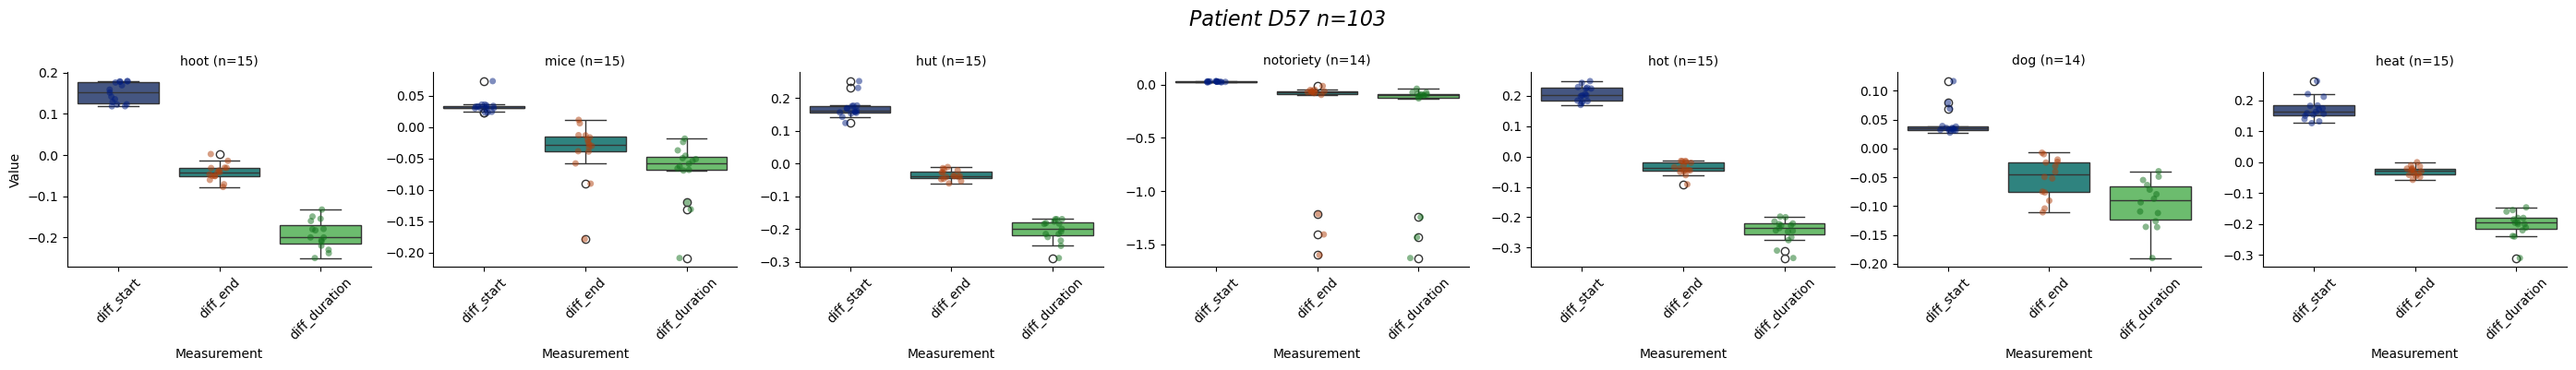

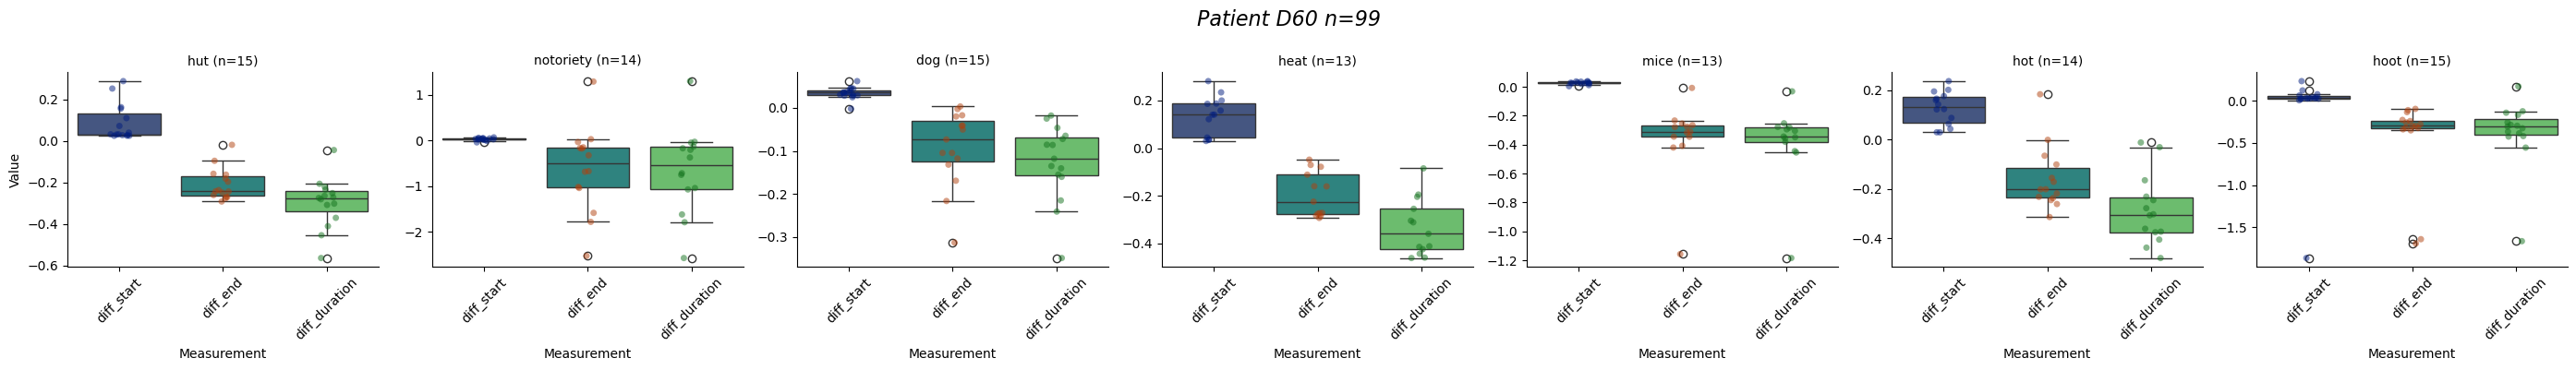

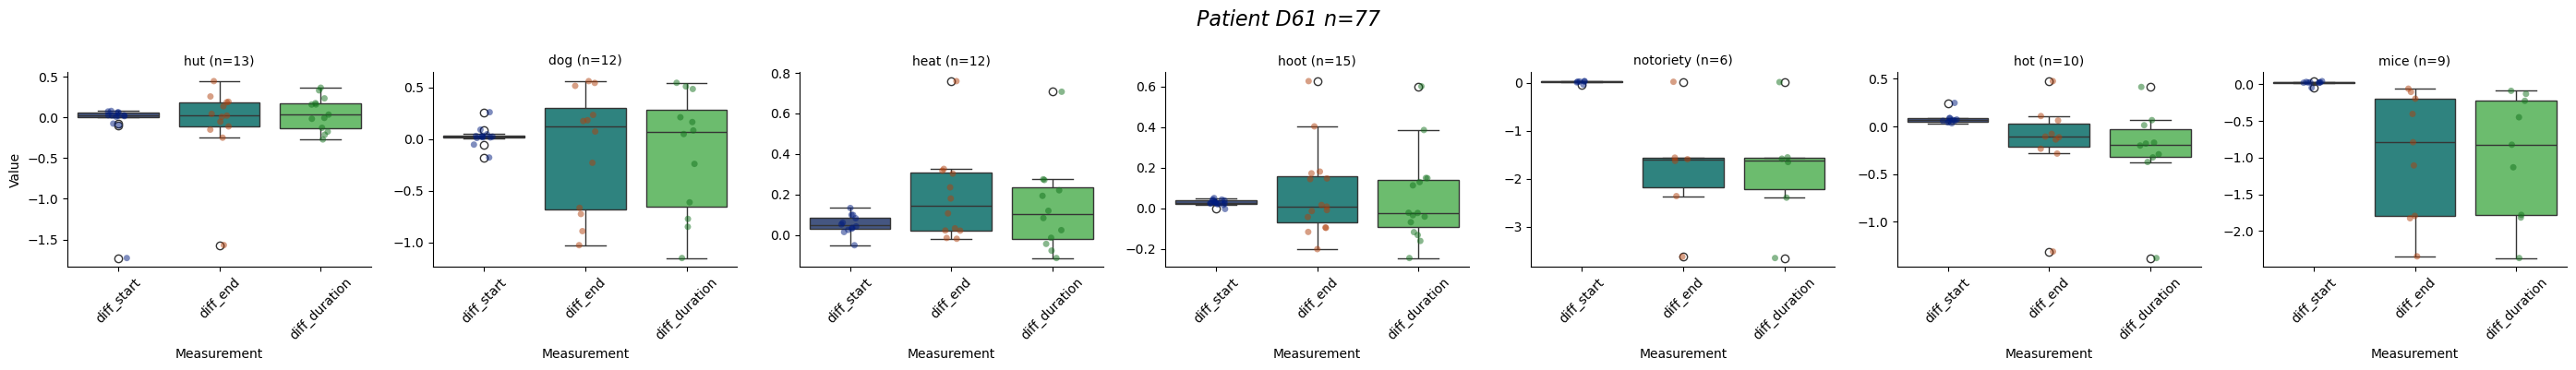

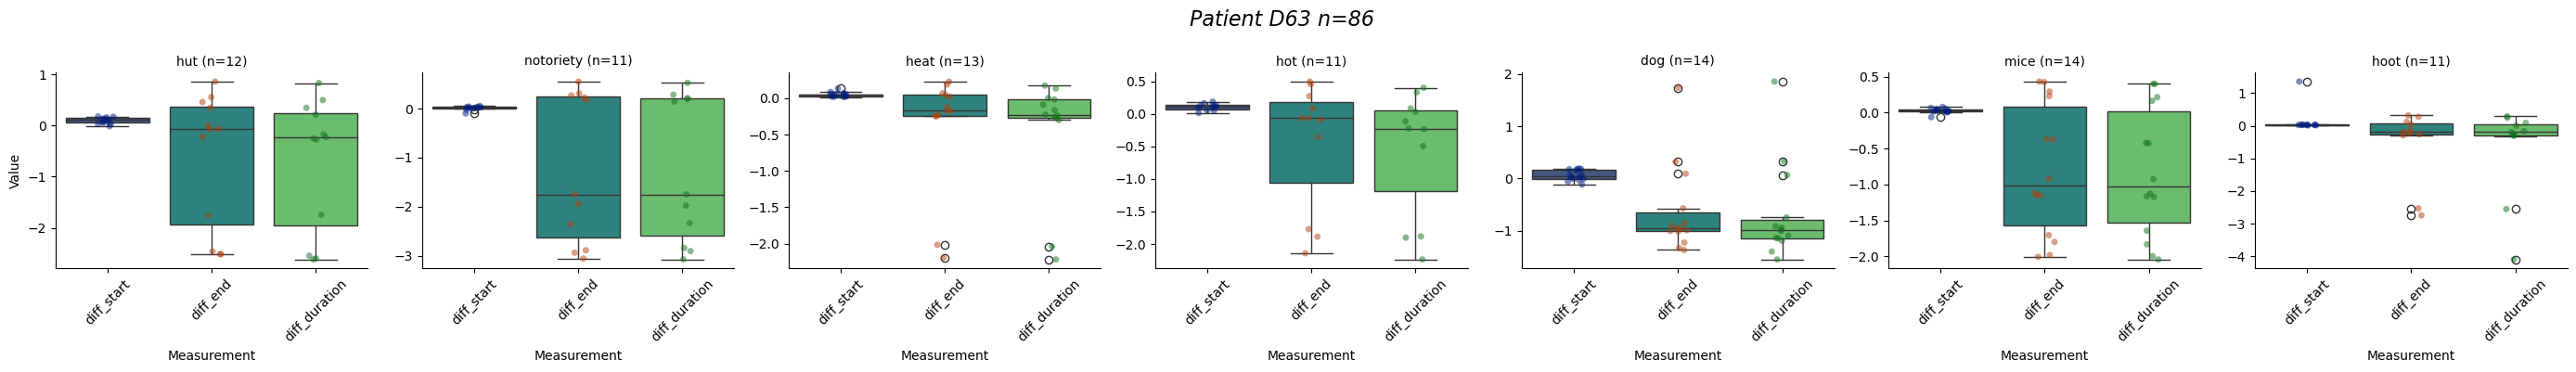

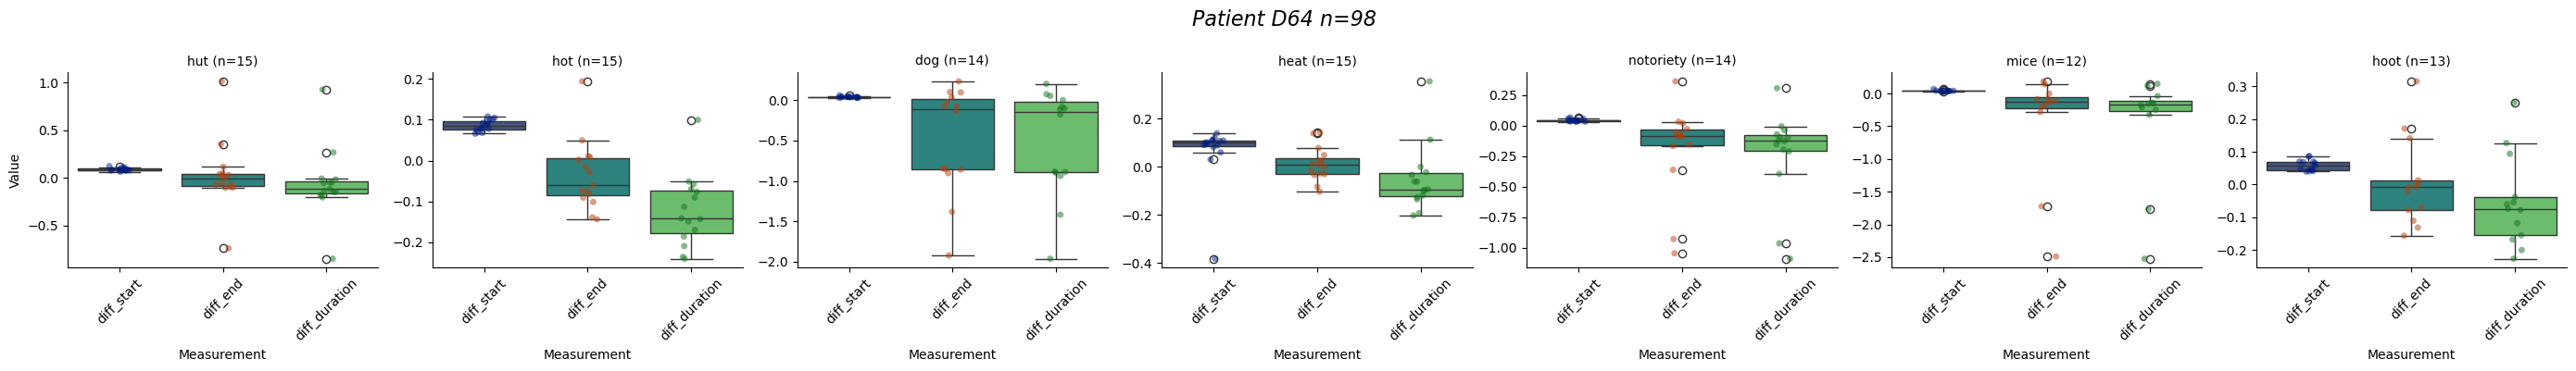

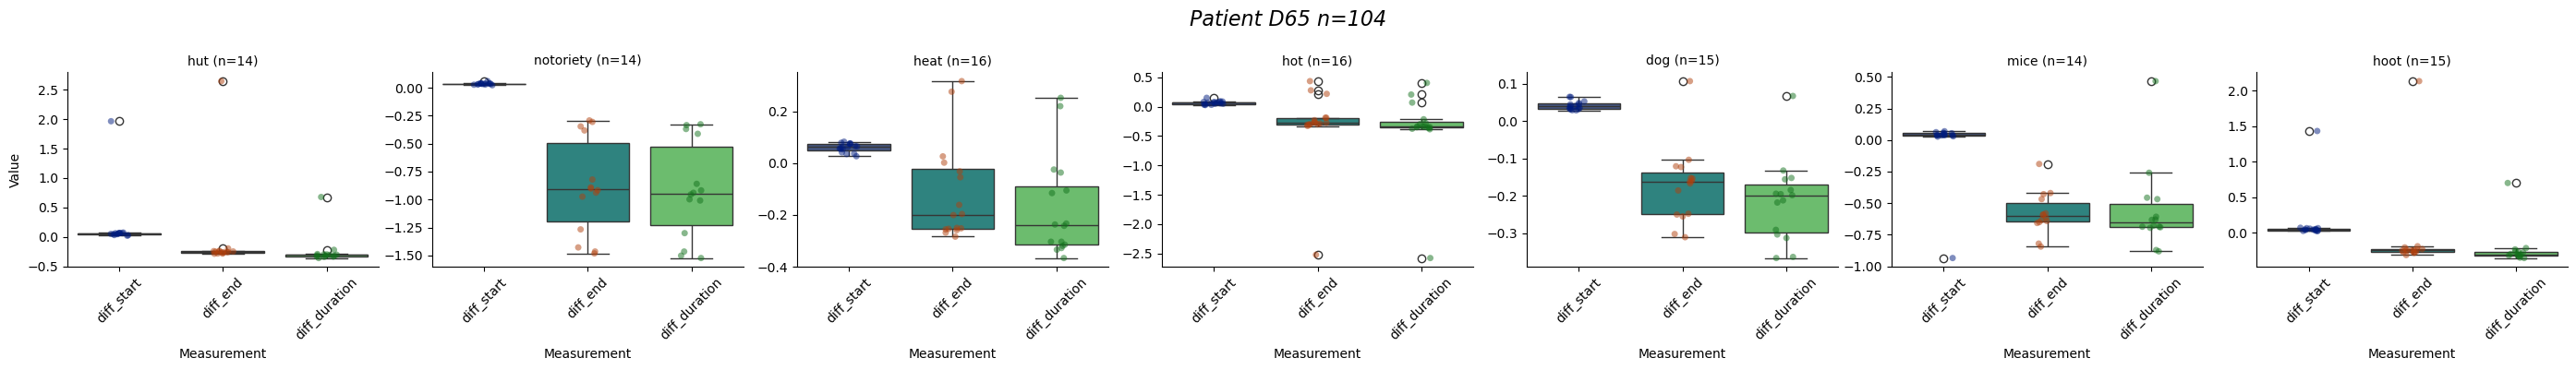

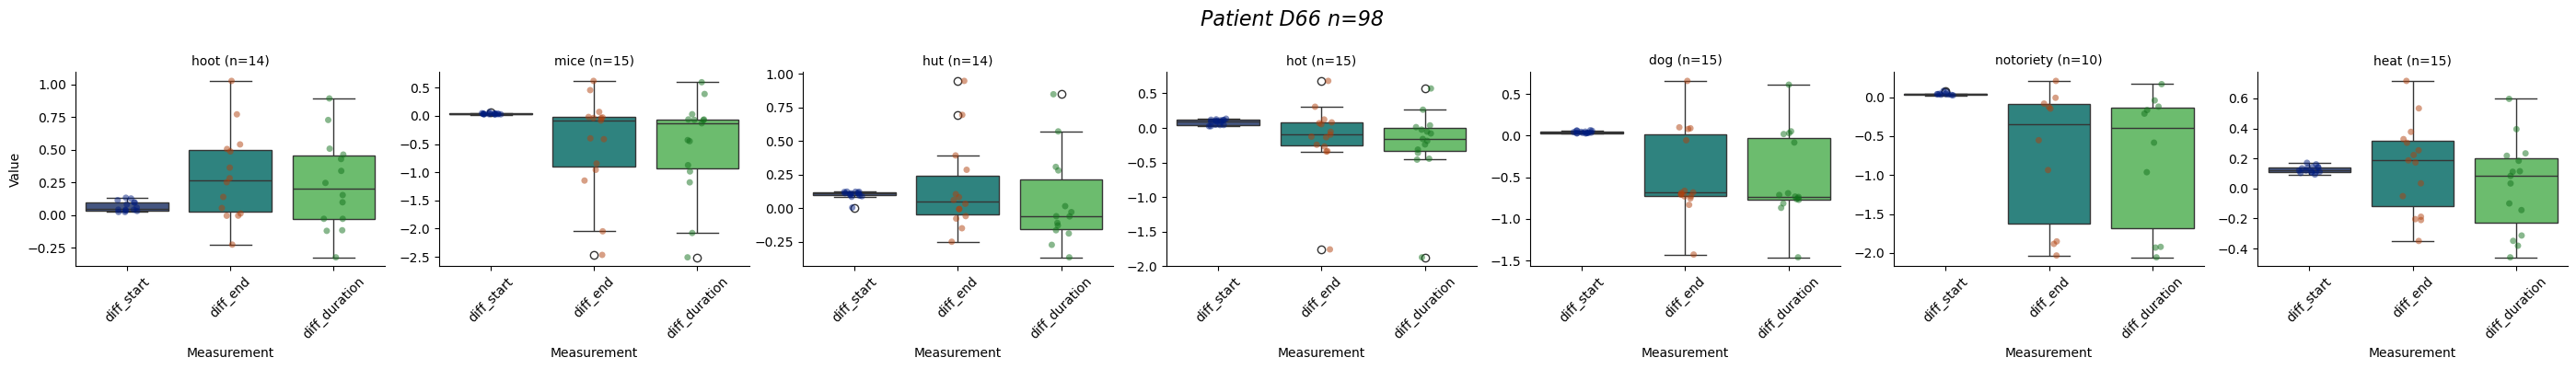

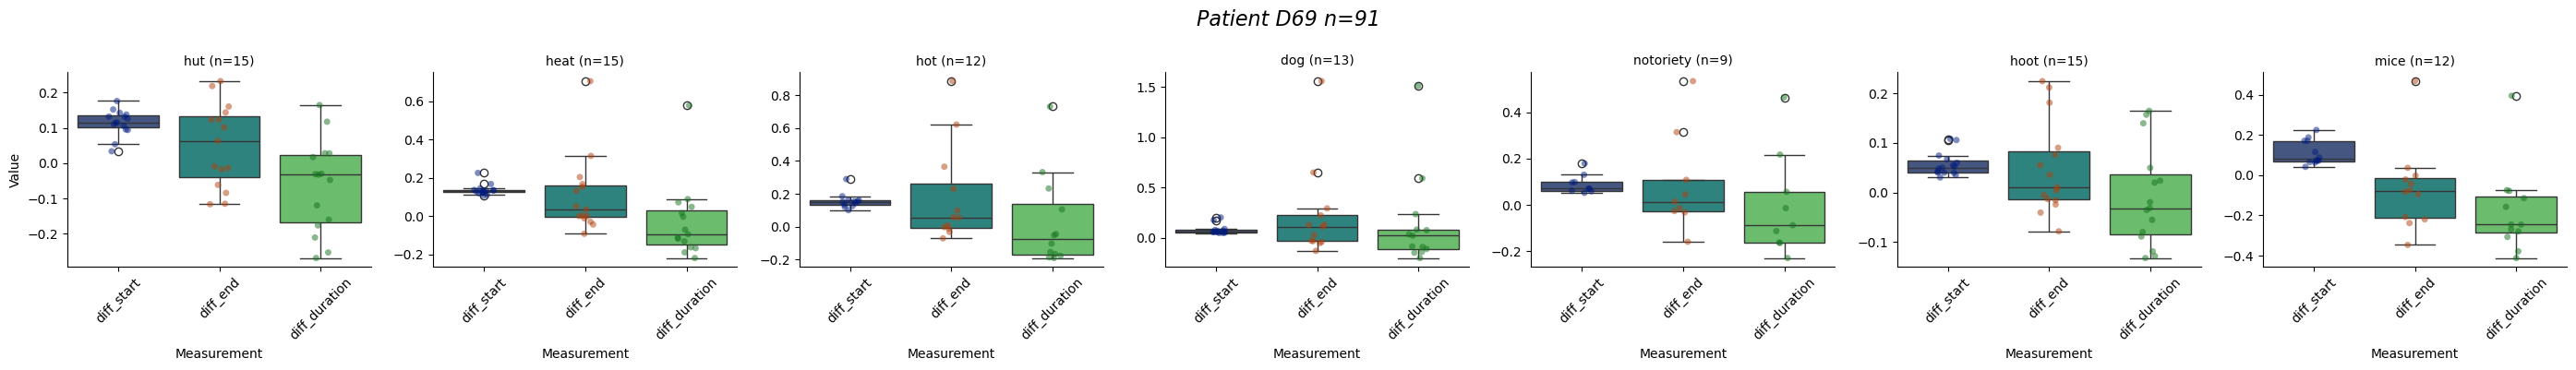

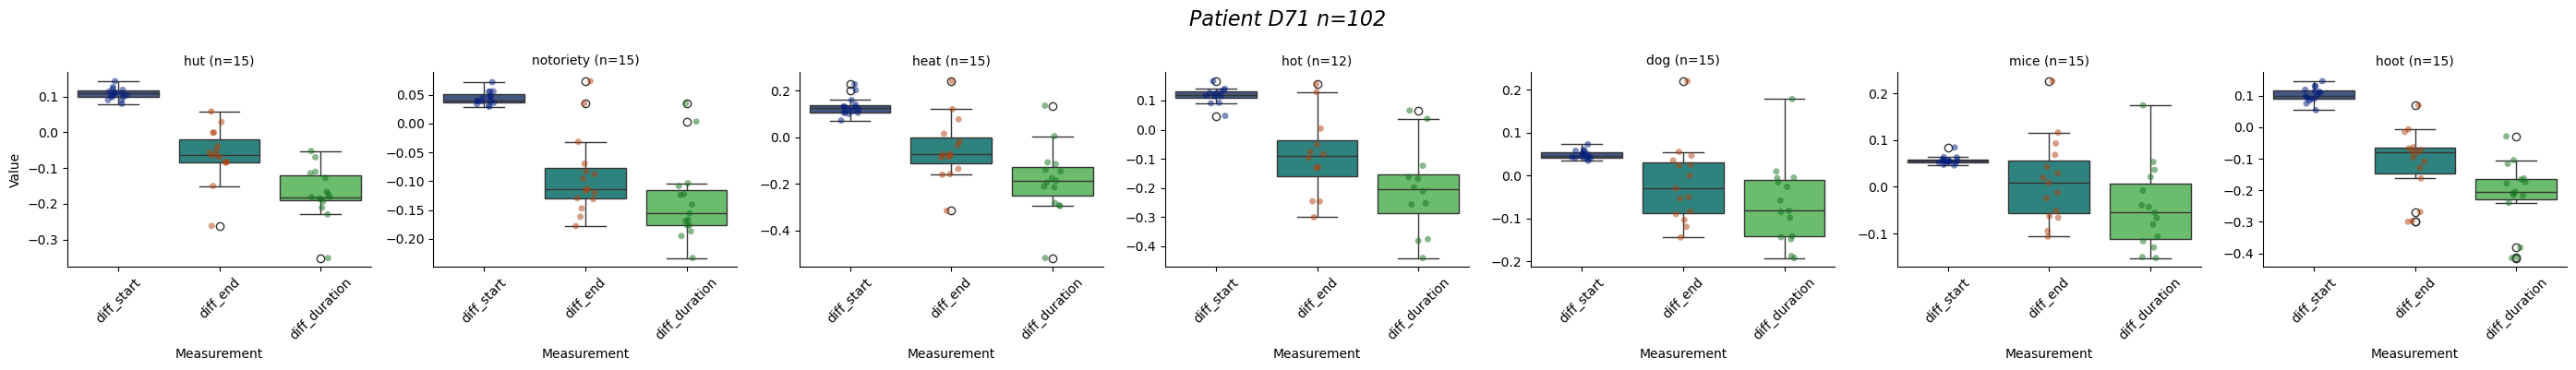

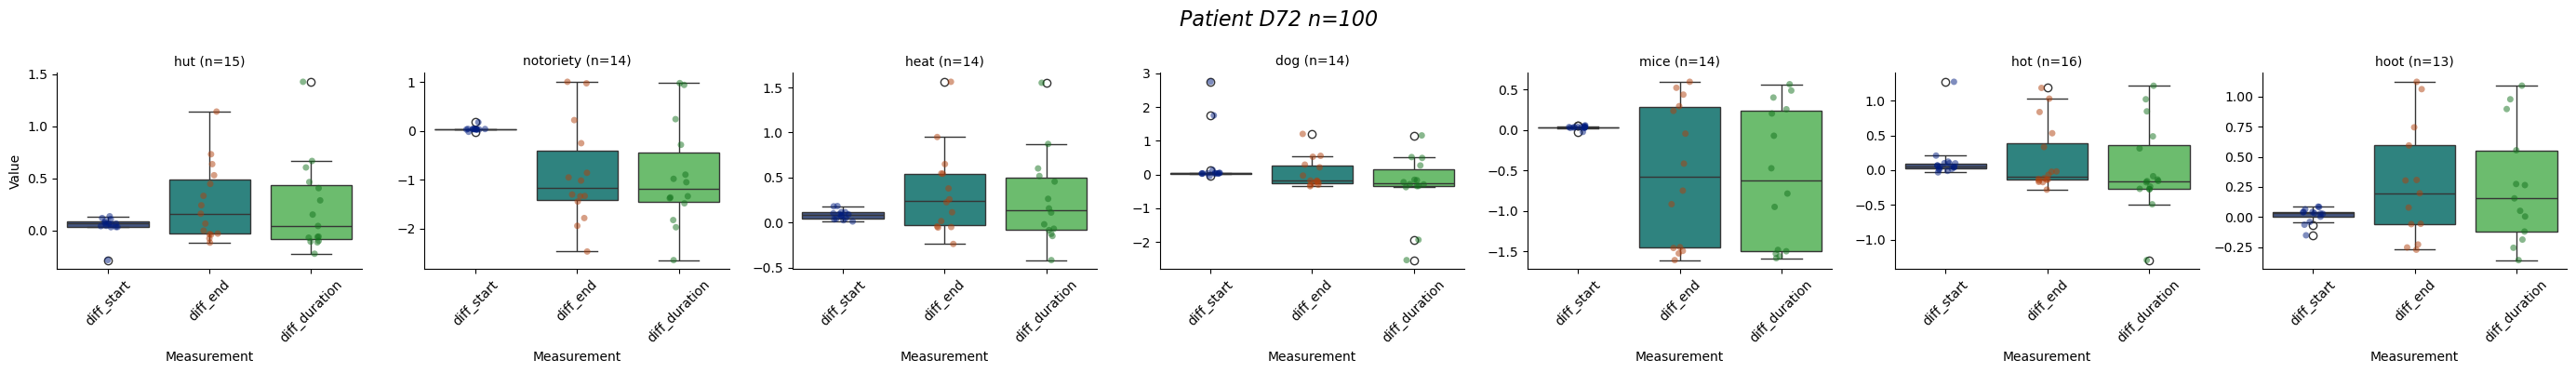

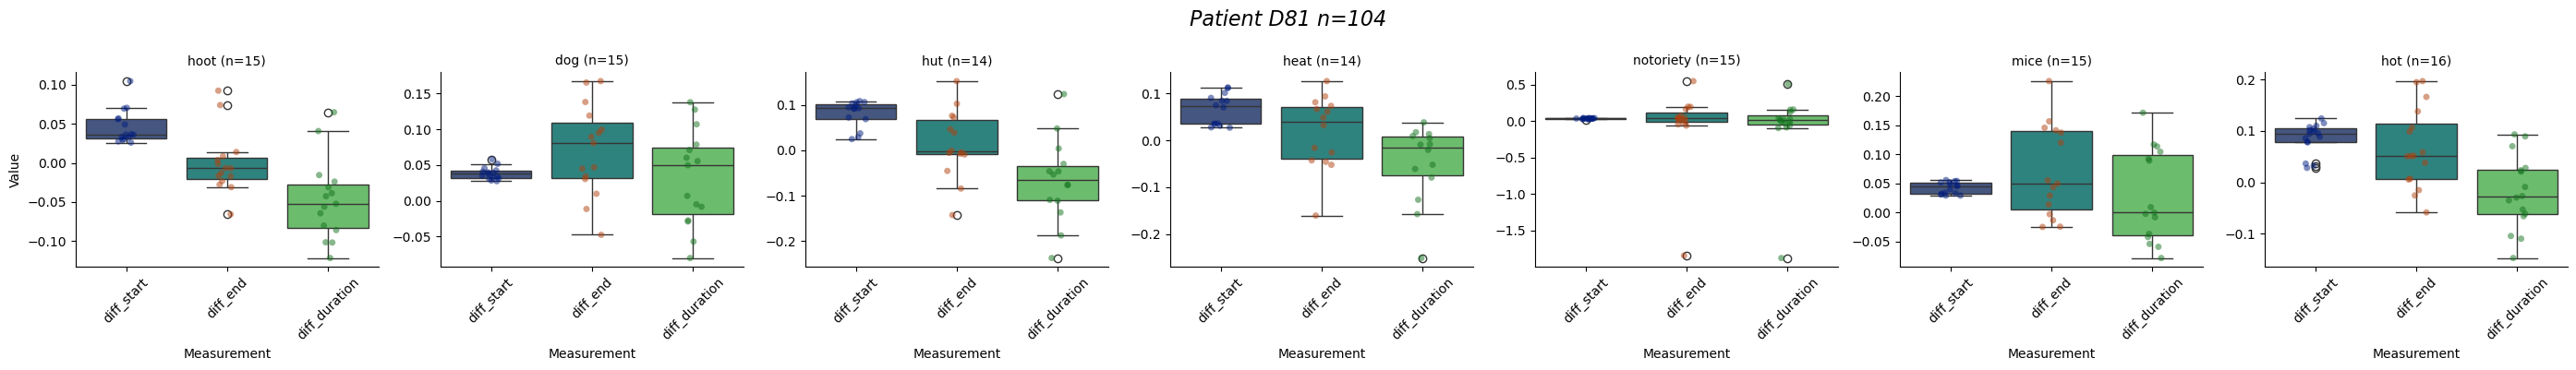

In [12]:
descr_path_2 = os.path.join(by_patient_directory, 'stats_bypat.txt')
with open(descr_path_2, 'w') as f:
    grouped = df.groupby('ID')
    
    for patient, group in grouped:
        stats = group[['diff_start', 'diff_end', 'diff_duration']].describe()
        
        f.write(f'{patient}\n')
        f.write(f'{stats}\n\n\n')

'''
================================================================================================
============================= Plotting Boxplots by Patient =====================================
================================================================================================
'''
unique_ids = df['ID'].unique()  

for id_value in unique_ids:
   


    
    df_filtered = df[df['ID'] == id_value]
    
    df_melted = df_filtered.melt(id_vars=['ID', 'label'], value_vars=['diff_start', 'diff_end', 'diff_duration'],
                                 var_name='Measurement', value_name='Value')
    
    label_counts = df_filtered['label'].value_counts().to_dict()
    
    measurements_order = ['diff_start', 'diff_end', 'diff_duration']
    
    g = sns.FacetGrid(df_melted, col='label', margin_titles=True, sharex=False, sharey=False, height=4)
    
    g.map(sns.boxplot, 'Measurement', 'Value', 'Measurement', hue='Measurement',
          order=measurements_order, hue_order=measurements_order, palette='viridis', dodge=False, legend=False)
    
    g.map(sns.stripplot, 'Measurement', 'Value', 'Measurement', hue='Measurement',
          order=measurements_order, hue_order=measurements_order, palette='dark', jitter=True, dodge=False, legend=False, alpha=0.5)
    g.fig.suptitle(f'Patient {id_value} n={df_filtered.shape[0]}', fontsize=16, y=0.99, style='italic')
   
    for ax in g.axes.flat:
        plt.setp(ax.get_xticklabels(), rotation=45)
    
    for ax, label in zip(g.axes.flat, df_melted['label'].unique()):
        ax.set_title(f'{label} (n={label_counts[label]})', fontsize=10)
    g.fig.subplots_adjust(hspace=0.4, wspace=0.4)

    g.tight_layout()
    plt.savefig(f'{by_patient_directory}{id_value}_boxplot.png')
    plt.show()
    plt.close()

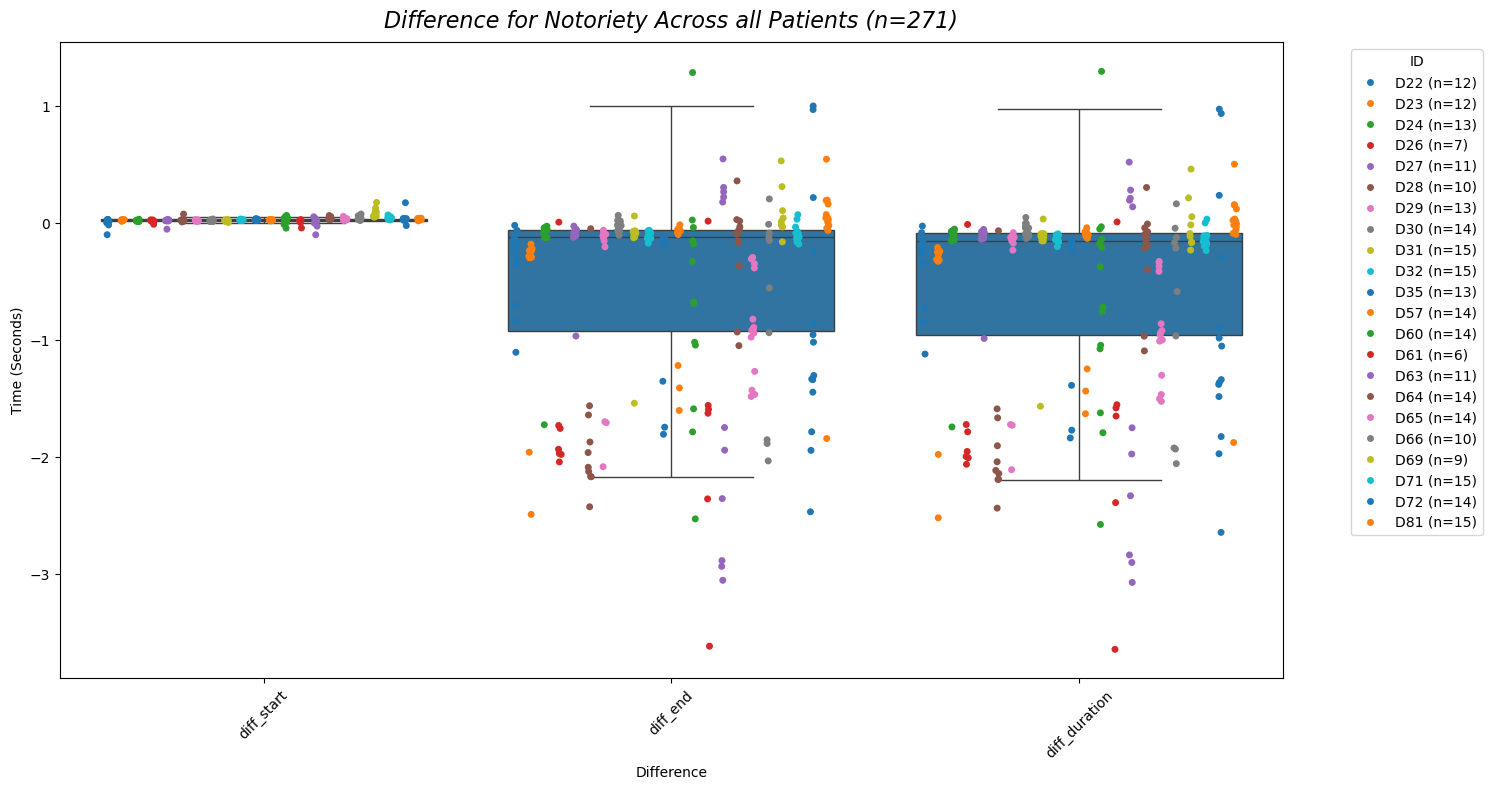

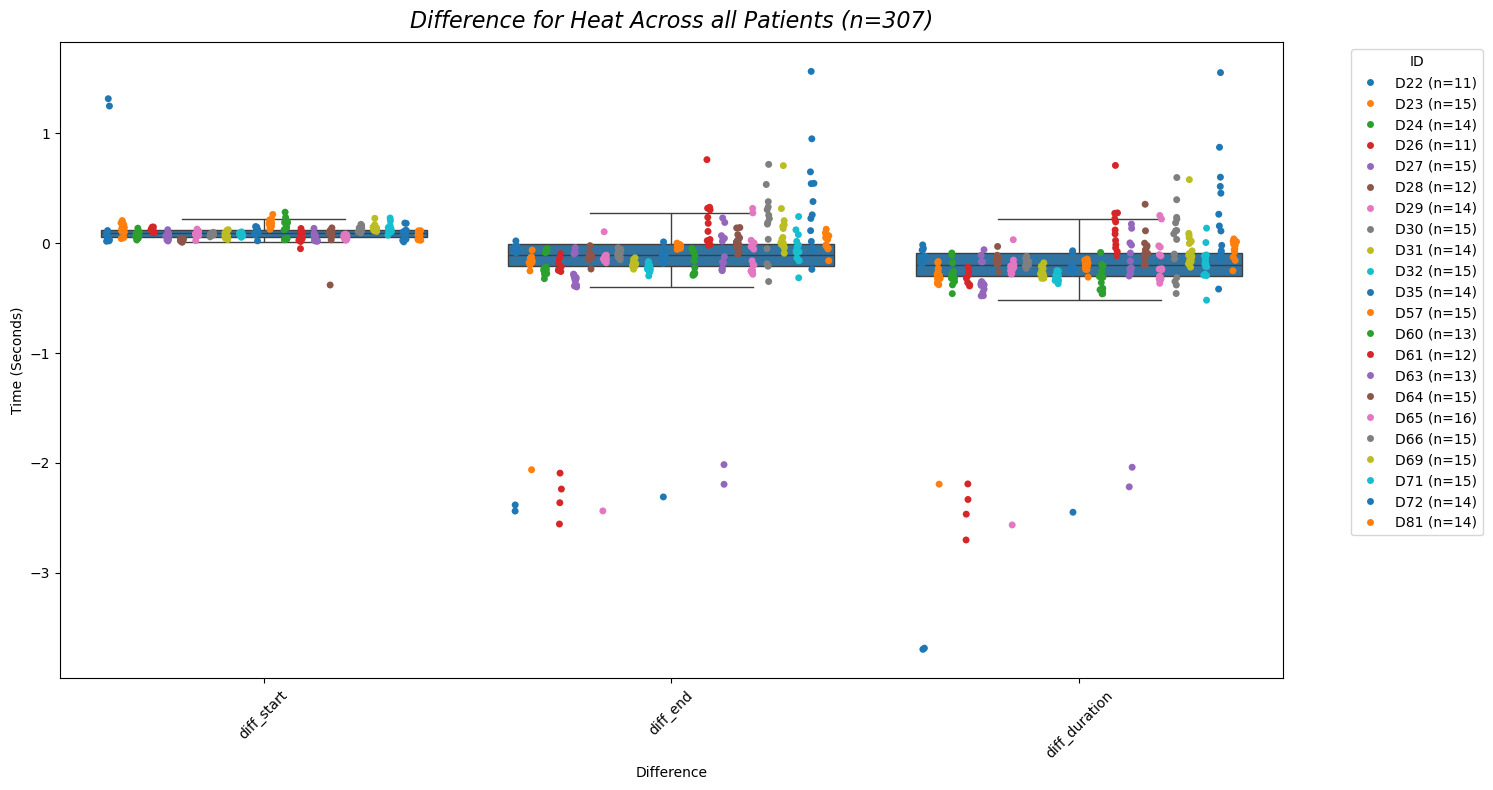

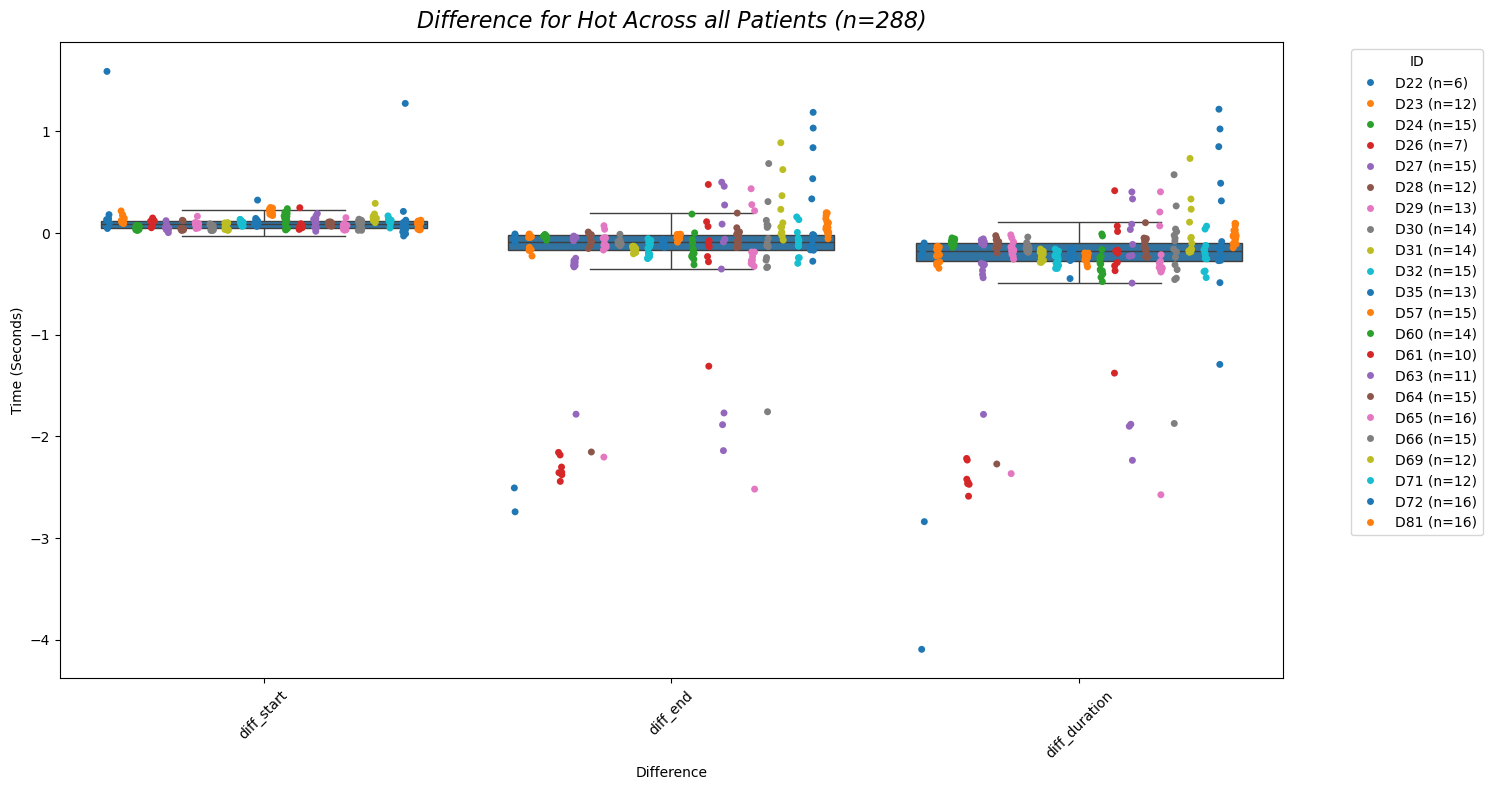

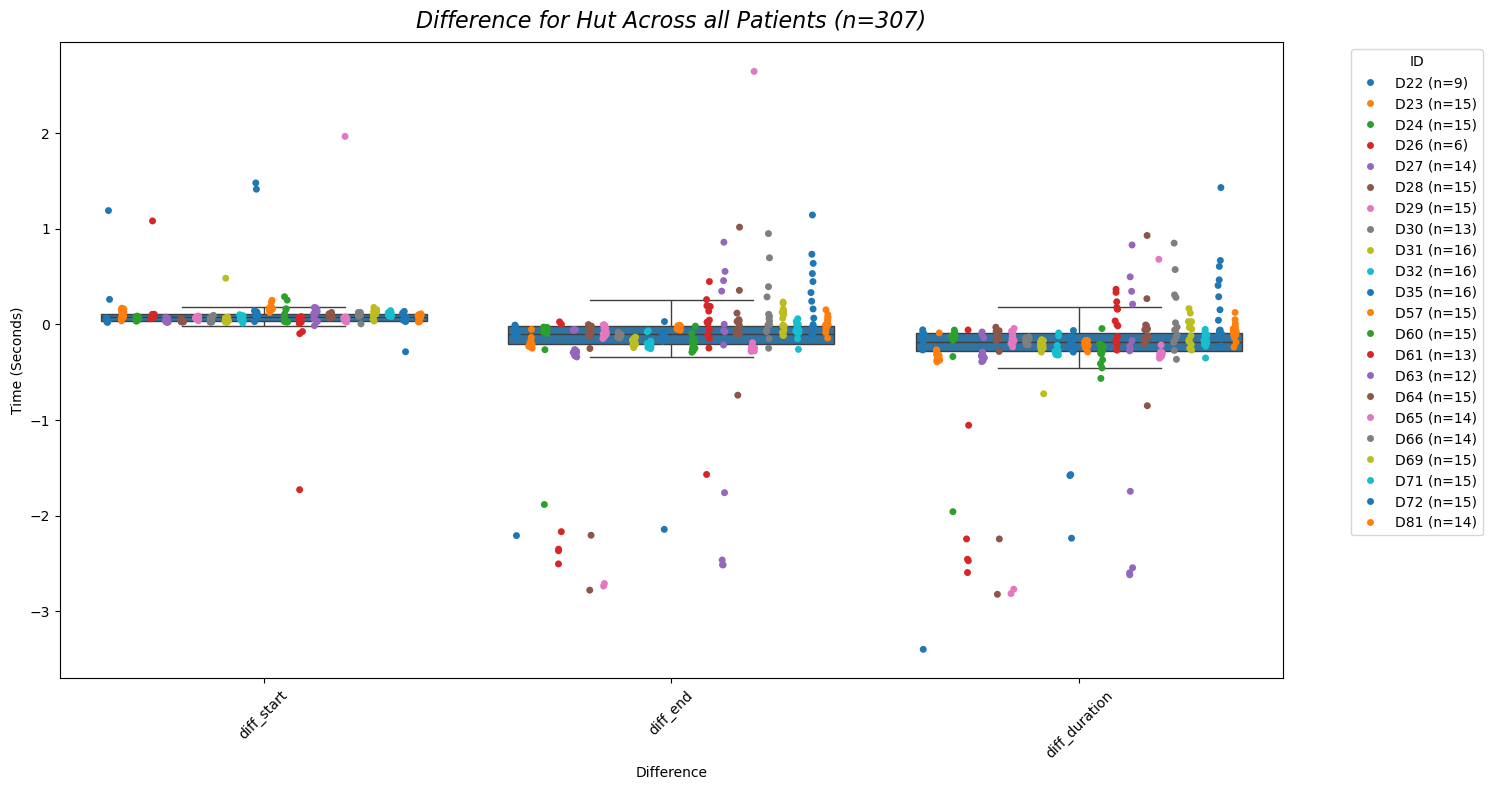

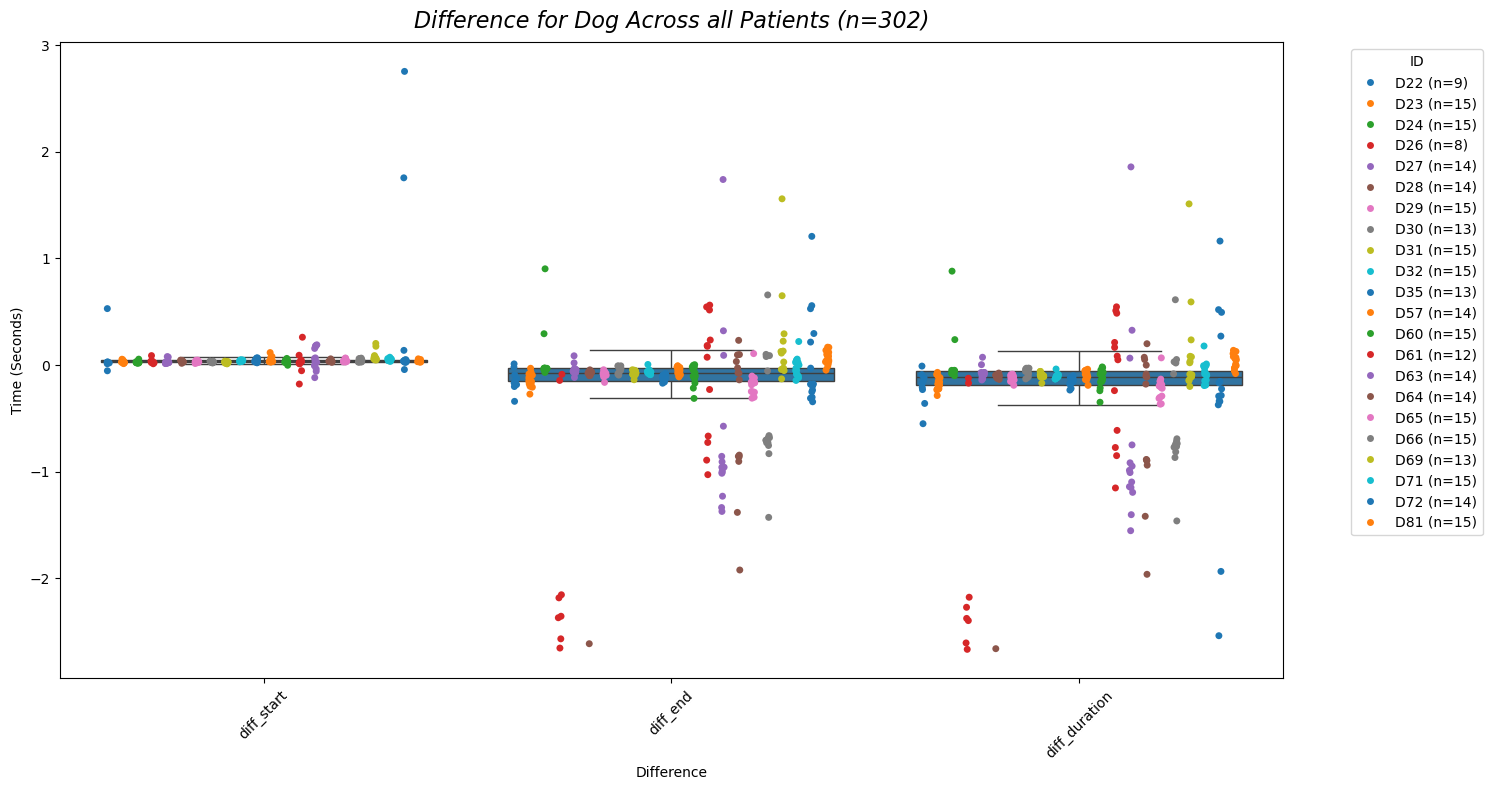

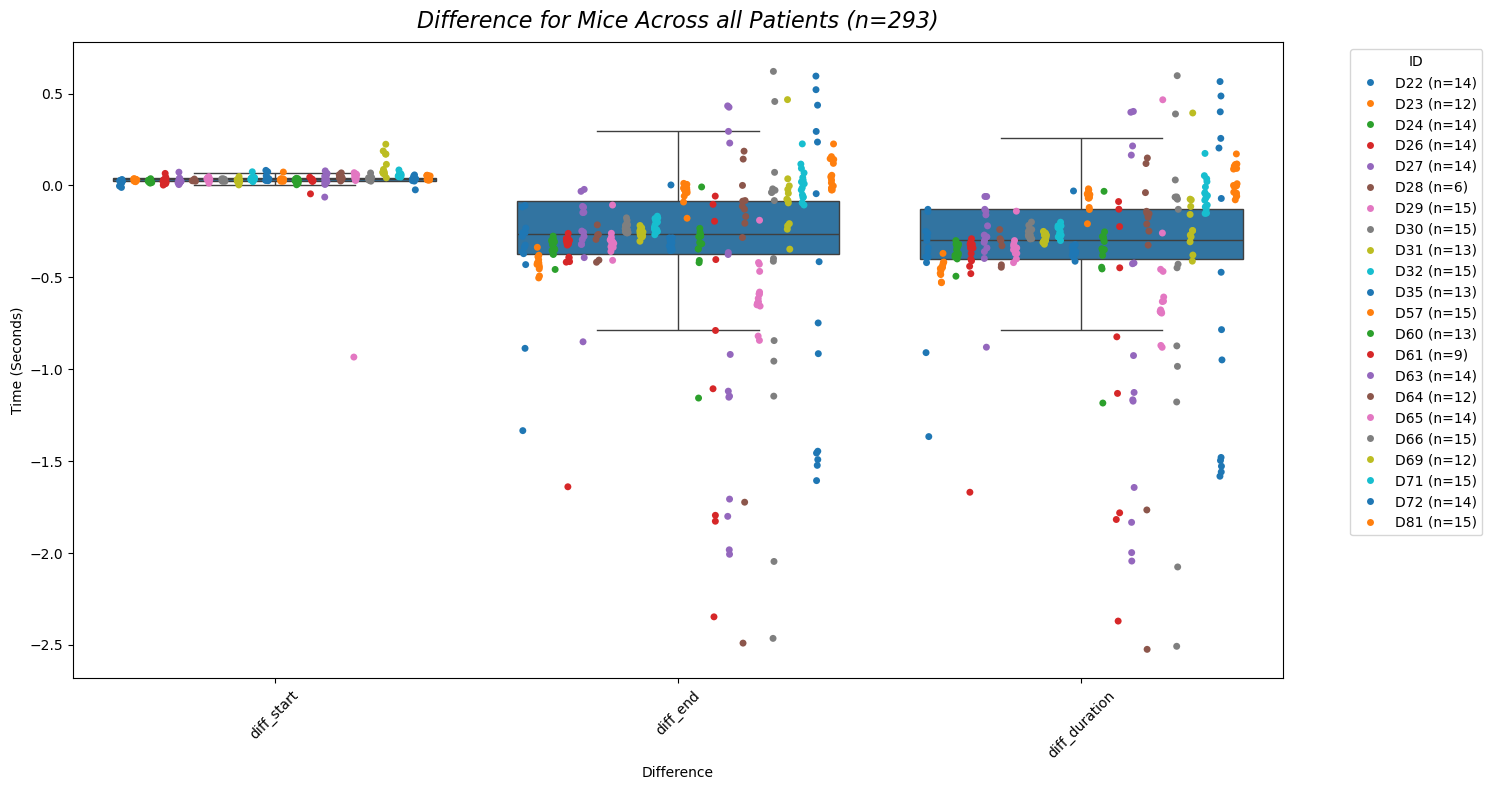

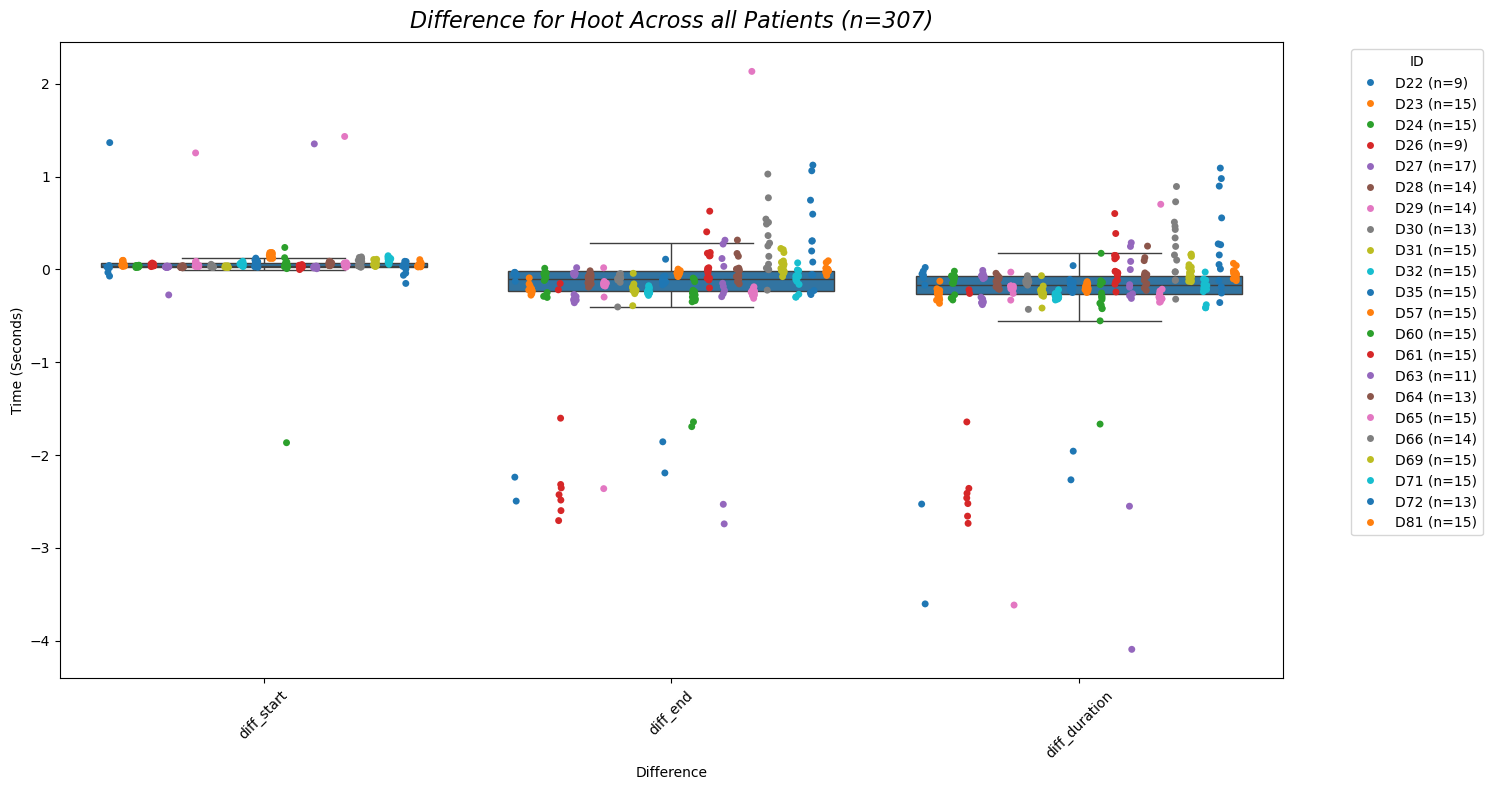

In [13]:
descr_path_3 = os.path.join(by_label_allpatients_directory, 'statsbylabbypat.txt')

with open(descr_path_3, 'w') as f:
    grouped = df.groupby(['label', 'ID'])
    
    for (label, patient), group in grouped:
        stats = group[['diff_start', 'diff_end', 'diff_duration']].describe()
        
        f.write(f'Label: {label}, Patient: {patient}\n')
        f.write(f'{stats}\n\n\n')

'''
================================================================================================
============================== Plotting Boxplots by Label for all Patients =====================
================================================================================================
'''

for label_value in df['label'].unique():
    df_filtered = df[df['label'] == label_value]
    
    df_melted = df_filtered.melt(id_vars=['ID', 'label'], value_vars=['diff_start', 'diff_end', 'diff_duration'],
                                 var_name='Difference', value_name='Time (Seconds)')
    
    plt.figure(figsize=(15, 8))
    
    sns.boxplot(x='Difference', y='Time (Seconds)', data=df_melted, showfliers=False)
    
    stripplot = sns.stripplot(x='Difference', y='Time (Seconds)', hue='ID', data=df_melted, jitter=True, dodge=True, palette='tab10')
    
    plt.title(f'Difference for {label_value.title()} Across all Patients (n={df_filtered.shape[0]})', fontsize=16, style='italic', y=1.01)
    plt.xticks(rotation=45)
    
    id_counts = df_filtered['ID'].value_counts().to_dict()
    
    handles, labels = stripplot.get_legend_handles_labels()
    new_labels = [f'{label} (n={id_counts[label]})' for label in labels]
    plt.legend(handles, new_labels, title='ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(os.path.join(by_label_allpatients_directory, f'{label_value}_boxplot.png'))
    plt.show()
    plt.close()

In [14]:
descr_path_4 = os.path.join(all_labels_all_patients_directory, 'stats_alllabbypat.txt')

with open(descr_path_4, 'w') as f:
    stats = df[['diff_start', 'diff_end', 'diff_duration']].describe()
    f.write(f'All Labels Across All Patients\n\n\n')
    f.write(f'{stats}\n\n\n')

df_melted = df.melt(id_vars=['ID', 'label'], value_vars=['diff_start', 'diff_end', 'diff_duration'], var_name='Difference', value_name='Time (Seconds)')
count = int(stats['diff_start']['count'])



In [15]:
import plotly.graph_objects as go


fig = go.Figure()

for diffi in df_melted['Difference'].unique():
    filtered_df = df_melted[df_melted['Difference'] == diffi]
    
    fig.add_trace(go.Box(
        y=filtered_df['Time (Seconds)'],
        x=filtered_df['Difference'],
        name=diffi,
        boxpoints='all', 
        jitter=1,
        marker_size = 3,
        hovertext=filtered_df[['ID', 'label']].agg(', '.join, axis=1)  # Combine ID and label for hover info    
    ))

fig.update_layout(
    title=f'All Labels Across All Patients (n={count})',
    xaxis_title='Difference',
    yaxis_title='Time (Seconds)',
    showlegend=False,
    title_x=0.5,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)'
)

fig.show()


In [16]:
df_melted.head()

ID      label  Difference  Time (Seconds)
0  D22  notoriety  diff_start        0.015060
1  D22       heat  diff_start        0.079047
2  D22        hot  diff_start        0.129736
3  D22        hut  diff_start        0.067289
4  D22        dog  diff_start        0.022330

In [17]:
# now repeat but for diff_start only

filtered_df = df_melted[df_melted['Difference'] == 'diff_start']
# now filtered_df has only diff_start values so we can plot this now

fig = go.Figure()
fig.add_trace(go.Box(
    y=filtered_df['Time (Seconds)'],
    x=filtered_df['Difference'],
    name='diff_start',
    boxpoints='all', 
    jitter=1,
    marker_size = 3,
    hovertext=filtered_df[['ID', 'label']].agg(', '.join, axis=1)  # Combine ID and label for hover info    
))

fig.update_layout(
    title=f'Difference in Start Times Across All Patients (n={count})',
    xaxis_title='',
    yaxis_title='Time (Seconds)',
    showlegend=False,
    title_x=0.5,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)'
)


C:\Users\Nabiya\AppData\Local\Temp\ipykernel_26168\1046712267.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Nabiya\AppData\Local\Temp\ipykernel_26168\1046712267.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




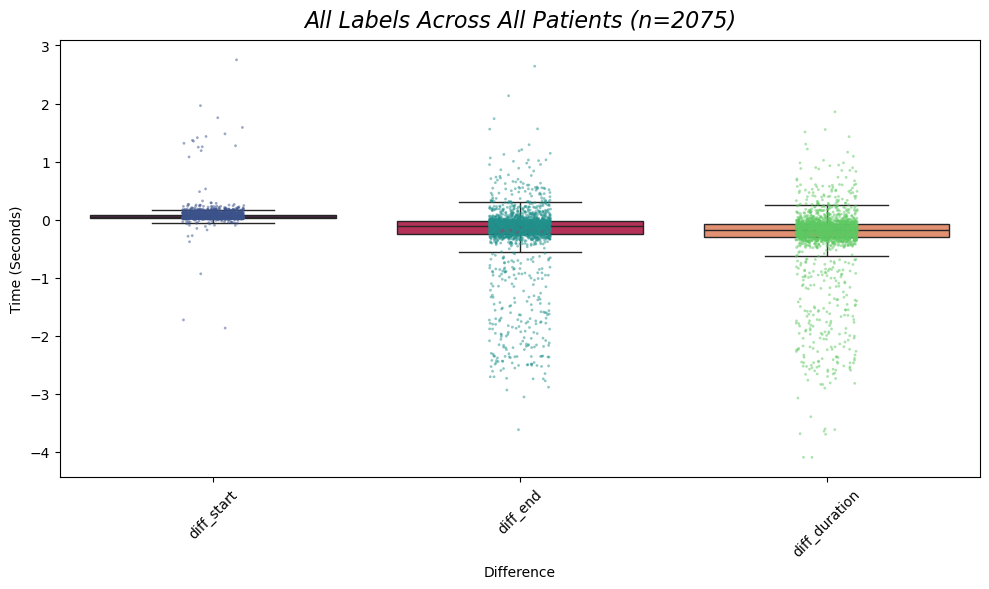

In [18]:


plt.figure(figsize=(10, 6))
sns.boxplot(x='Difference', y='Time (Seconds)', data=df_melted, showfliers=False, palette='rocket')
sns.stripplot(x='Difference', y='Time (Seconds)', data=df_melted, jitter=True, dodge=False, palette='viridis', alpha=0.5, size=2)
plt.title(f'All Labels Across All Patients (n={count})', fontsize=16, style='italic', y=1.01)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(all_labels_all_patients_directory, 'all_labels_boxplot.png'))
plt.show()
plt.close()


    

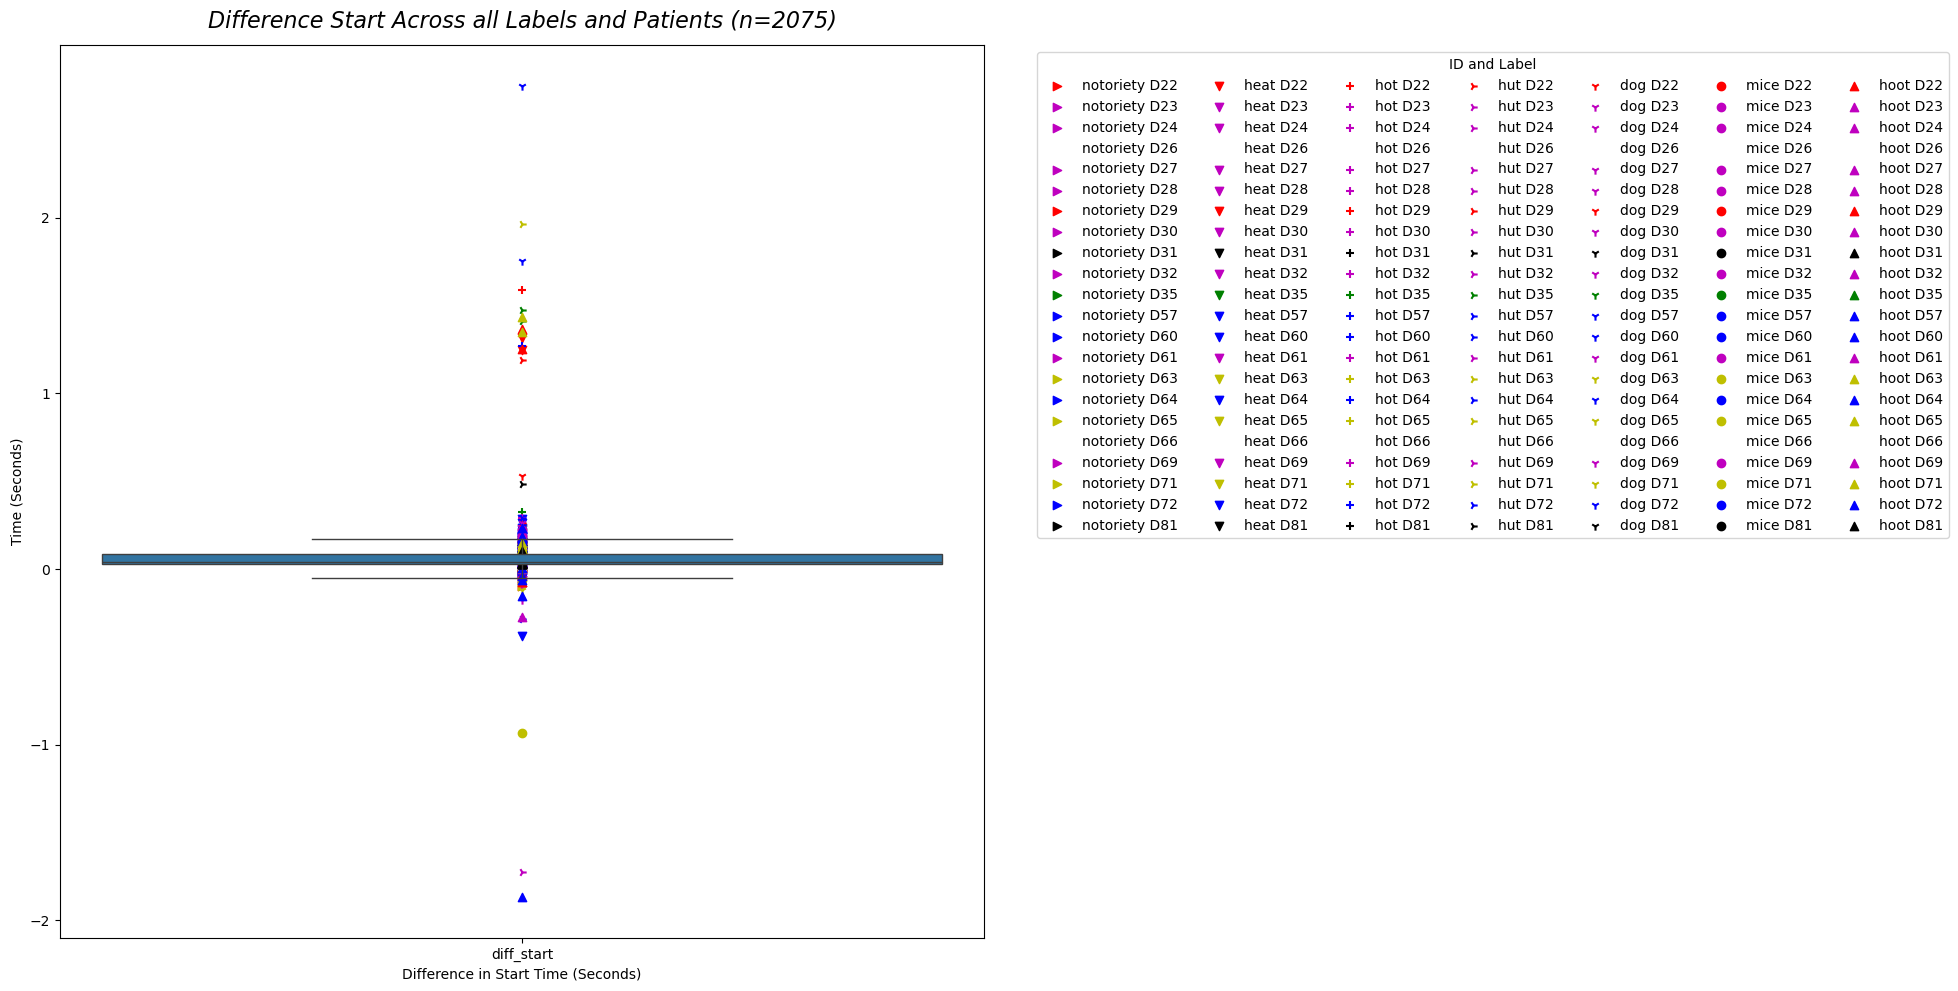

In [19]:
# let's analyze diff_start only for all labels and all patients

df_melted = df.melt(id_vars=['ID', 'label'], value_vars=['diff_start'], var_name='Difference', value_name='Time (Seconds)')

unique_labels = df_melted['label'].unique()
unique_ids = df_melted['ID'].unique()
# generate len(labels) markers for the scatter plot
marker_dict = {label: np.random.choice(['o', 'v', '^', '<', '>', 's', 'p', '*', '+', 'x', 'D', 'd', '1', '2', '3', '4', 'h', 'H', '|', '_'], replace = False) for label in unique_labels}
color_dict = {ID: np.random.choice(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'], replace=False) for ID in unique_ids}

plt.figure(figsize=(20, 10))
sns.boxplot(x='Difference', y='Time (Seconds)', data=df_melted, showfliers=False)

for label in unique_labels:
    filtered_df = df_melted[df_melted['label'] == label]
    for id in unique_ids:
        filtered_id_df = filtered_df[filtered_df['ID'] == id]
        plt.scatter(filtered_id_df['Difference'], filtered_id_df['Time (Seconds)'], label=f'{label} {id}', marker=marker_dict[label], color=color_dict[id])
num_obs = df_melted.shape[0]
plt.title(f'Difference Start Across all Labels and Patients (n={num_obs})', fontsize=16, style='italic', y=1.01)
plt.xlabel('Difference in Start Time (Seconds)')
id_counts = df_melted['ID'].value_counts().to_dict()
lable_counts = df_melted['label'].value_counts().to_dict()
# make legend have len(labels) columns 
plt.legend(title='ID and Label', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=len(unique_labels))
plt.tight_layout()
plt.savefig(os.path.join(all_labels_all_patients_directory, 'diff_start_all_labels_boxplot.png'))
plt.show()
plt.close()



In [20]:
# do teh same with plotly now 


df_melted = df.melt(id_vars=['ID', 'label'], value_vars=['diff_start'], var_name='Difference', value_name='Time (Seconds)')
stats = df_melted['Time (Seconds)'].describe()
count = int(stats['count'])
#print(stats['count'])

import plotly.graph_objects as go
import plotly.express as px

# Calculate mean and median
mean_time = df_melted['Time (Seconds)'].mean()
median_time = df_melted['Time (Seconds)'].median()

import plotly.express as px
bin_width = 0.1
bins = int((df_melted['Time (Seconds)'].max() - df_melted['Time (Seconds)'].min()) / bin_width)
# Create the histogram
fig = px.histogram(df_melted, x='Time (Seconds)', nbins = bins, hover_data=['ID', 'label'], title=f'Distribution of Time (Seconds) Across all Labels and Patients (n={count})')

# Add a line for the mean
fig.add_trace(go.Scatter(x=[mean_time, mean_time], y=[0, count], mode='lines',
                         line=dict(color='green', width=2),
                         name='Mean',
                         text=[f'Mean: {mean_time}'],
                         textposition='top center',
                         hoverinfo='x+text'))

# Add a line for the median
fig.add_trace(go.Scatter(x=[median_time, median_time], y=[0, count], mode='lines',
                         line=dict(color='orange', width=2),
                         name='Median',
                         text=[f'Median: {median_time}'],
                         textposition='top center',
                         hoverinfo='x+text'))
# Adjust the layout
fig.update_layout(
    title=f'Distribution of Time (Seconds) Across all Labels and Patients (n={count})',
    xaxis_title='Time (Seconds)',
    yaxis_title='Count',
    showlegend=True,
    title_x=0.5,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)', 
    height=800, width=2000
)

# Show the figure
fig.show()
